In [347]:
import scanpy as sc
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import time
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.sparse import csr_matrix
from scipy.stats import hypergeom

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import time

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 200)
sc.set_figure_params(figsize=(20, 4))
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'NimbusSanL'

In [51]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4i_final'
experiment_name = 'CD4i_final'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results_corrected.h5ad', backed='r')
de_summary_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)
cluster_nde75_ntotal50 = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.csv', index_col=0)

In [327]:
de_summary_stats[de_summary_stats.target_name_corrected=='MYDGF']

target_contrast target_name condition  n_cells_target  n_up_genes  \
5742   ENSG00000074842       MYDGF   Stim8hr           634.0           3   
7489   ENSG00000074842       MYDGF      Rest           871.0           1   
13390  ENSG00000074842       MYDGF  Stim48hr           773.0           1   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
5742              9                12            -35.152241   
7489              8                 9            -27.300922   
13390             5                 6            -32.062224   

       ontarget_significant    baseMean  offtarget_flag  \
5742                   True  243.674832           False   
7489                   True  112.606596           False   
13390                  True  202.475273           False   

      n_total_genes_category ontarget_effect_category  \
5742            >10 DE genes             on-target KD   
7489           2-10 DE genes             on-target KD   
13390          2-10 DE genes             on-target KD   

      target_contrast_corrected                 obs_names  \
5742            ENSG00000074842   ENSG00000074842_Stim8hr   
7489            ENSG00000074842      ENSG00000074842_Rest   
13390           ENSG00000074842  ENSG00000074842_Stim48hr   

      target_name_corrected  
5742                  MYDGF  
7489                  MYDGF  
13390                 MYDGF

In [57]:
cluster_nde75_ntotal50[cluster_nde75_ntotal50.target_contrast_gene_name_corrected=='SGF29']

target_contrast_gene_name culture_condition  \
ENSG00000176476_Rest                         SGF29              Rest   
ENSG00000176476_Stim48hr                     SGF29          Stim48hr   
ENSG00000176476_Stim8hr                      SGF29           Stim8hr   

                          target_contrast  chunk  n_cells_target  \
ENSG00000176476_Rest      ENSG00000176476    250          1087.0   
ENSG00000176476_Stim48hr  ENSG00000176476    449           993.0   
ENSG00000176476_Stim8hr   ENSG00000176476    626          1062.0   

                         target_contrast_corrected  \
ENSG00000176476_Rest               ENSG00000176476   
ENSG00000176476_Stim48hr           ENSG00000176476   
ENSG00000176476_Stim8hr            ENSG00000176476   

                         target_contrast_gene_name_corrected  hdbscan  
ENSG00000176476_Rest                                   SGF29       10  
ENSG00000176476_Stim48hr                               SGF29        9  
ENSG00000176476_Stim8hr                                SGF29       10

In [318]:
immune_genes_df = pd.read_csv('../../metadata/immune_effector_genes.csv')
cytokines = immune_genes_df[immune_genes_df['Category'] == 'Cytokine']['gene_name'].tolist()

exclude = ['IL17F','IL6','IL17A','CCL20','IL31','CXCL13','IL23A']#,'MYDGF','VEGFA','VEGFB']#,'IL32','LTB'] 
cytokines = [x for x in cytokines if x not in exclude]
len(cytokines)

29

In [319]:
# Filtering
adata_cytokine = adata_de[:,adata_de.var.gene_name.isin(cytokines)].to_memory().copy()
adata_cytokine = adata_cytokine[adata_cytokine.obs.culture_condition=='Stim8hr'].copy()
#masked_zscore = adata_cytokine.layers['masked_zscore'].copy()
#masked_zscore[adata_cytokine.layers['adj_p_value']>=0.1] = 0
#adata_cytokine.layers['masked_zscore'] = masked_zscore.copy()

In [320]:
adata_cytokine

AnnData object with n_obs × n_vars = 11415 × 29
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'masked_zscore', 'p_value', 'zscore'

In [248]:
mask = (adata_cytokine.layers['adj_p_value']<0.05).any(axis=1) & (np.max(np.abs(adata_cytokine.layers['masked_zscore']),axis=1)>5)
#mask = mask & np.max(np.abs(adata_cytokine.layers['masked_zscore']),axis=1)>5 # & (adata_cytokine.obs.target_contrast_gene_name_corrected.isin(strong_gene_list))
adata = adata_cytokine[mask].copy()
adata.var_names = adata.var.gene_name.copy()

In [288]:
adata = adata_cytokine[selected_obs_list, :].copy()
adata.var_names = adata.var.gene_name.copy()
adata.obs_names = adata.obs.target_contrast_gene_name_corrected.copy()

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/anndata/_core/anndata.py:842: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['RRAGA', 'CHD6', 'TMX1', 'PRRC2A', 'UGDH']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")


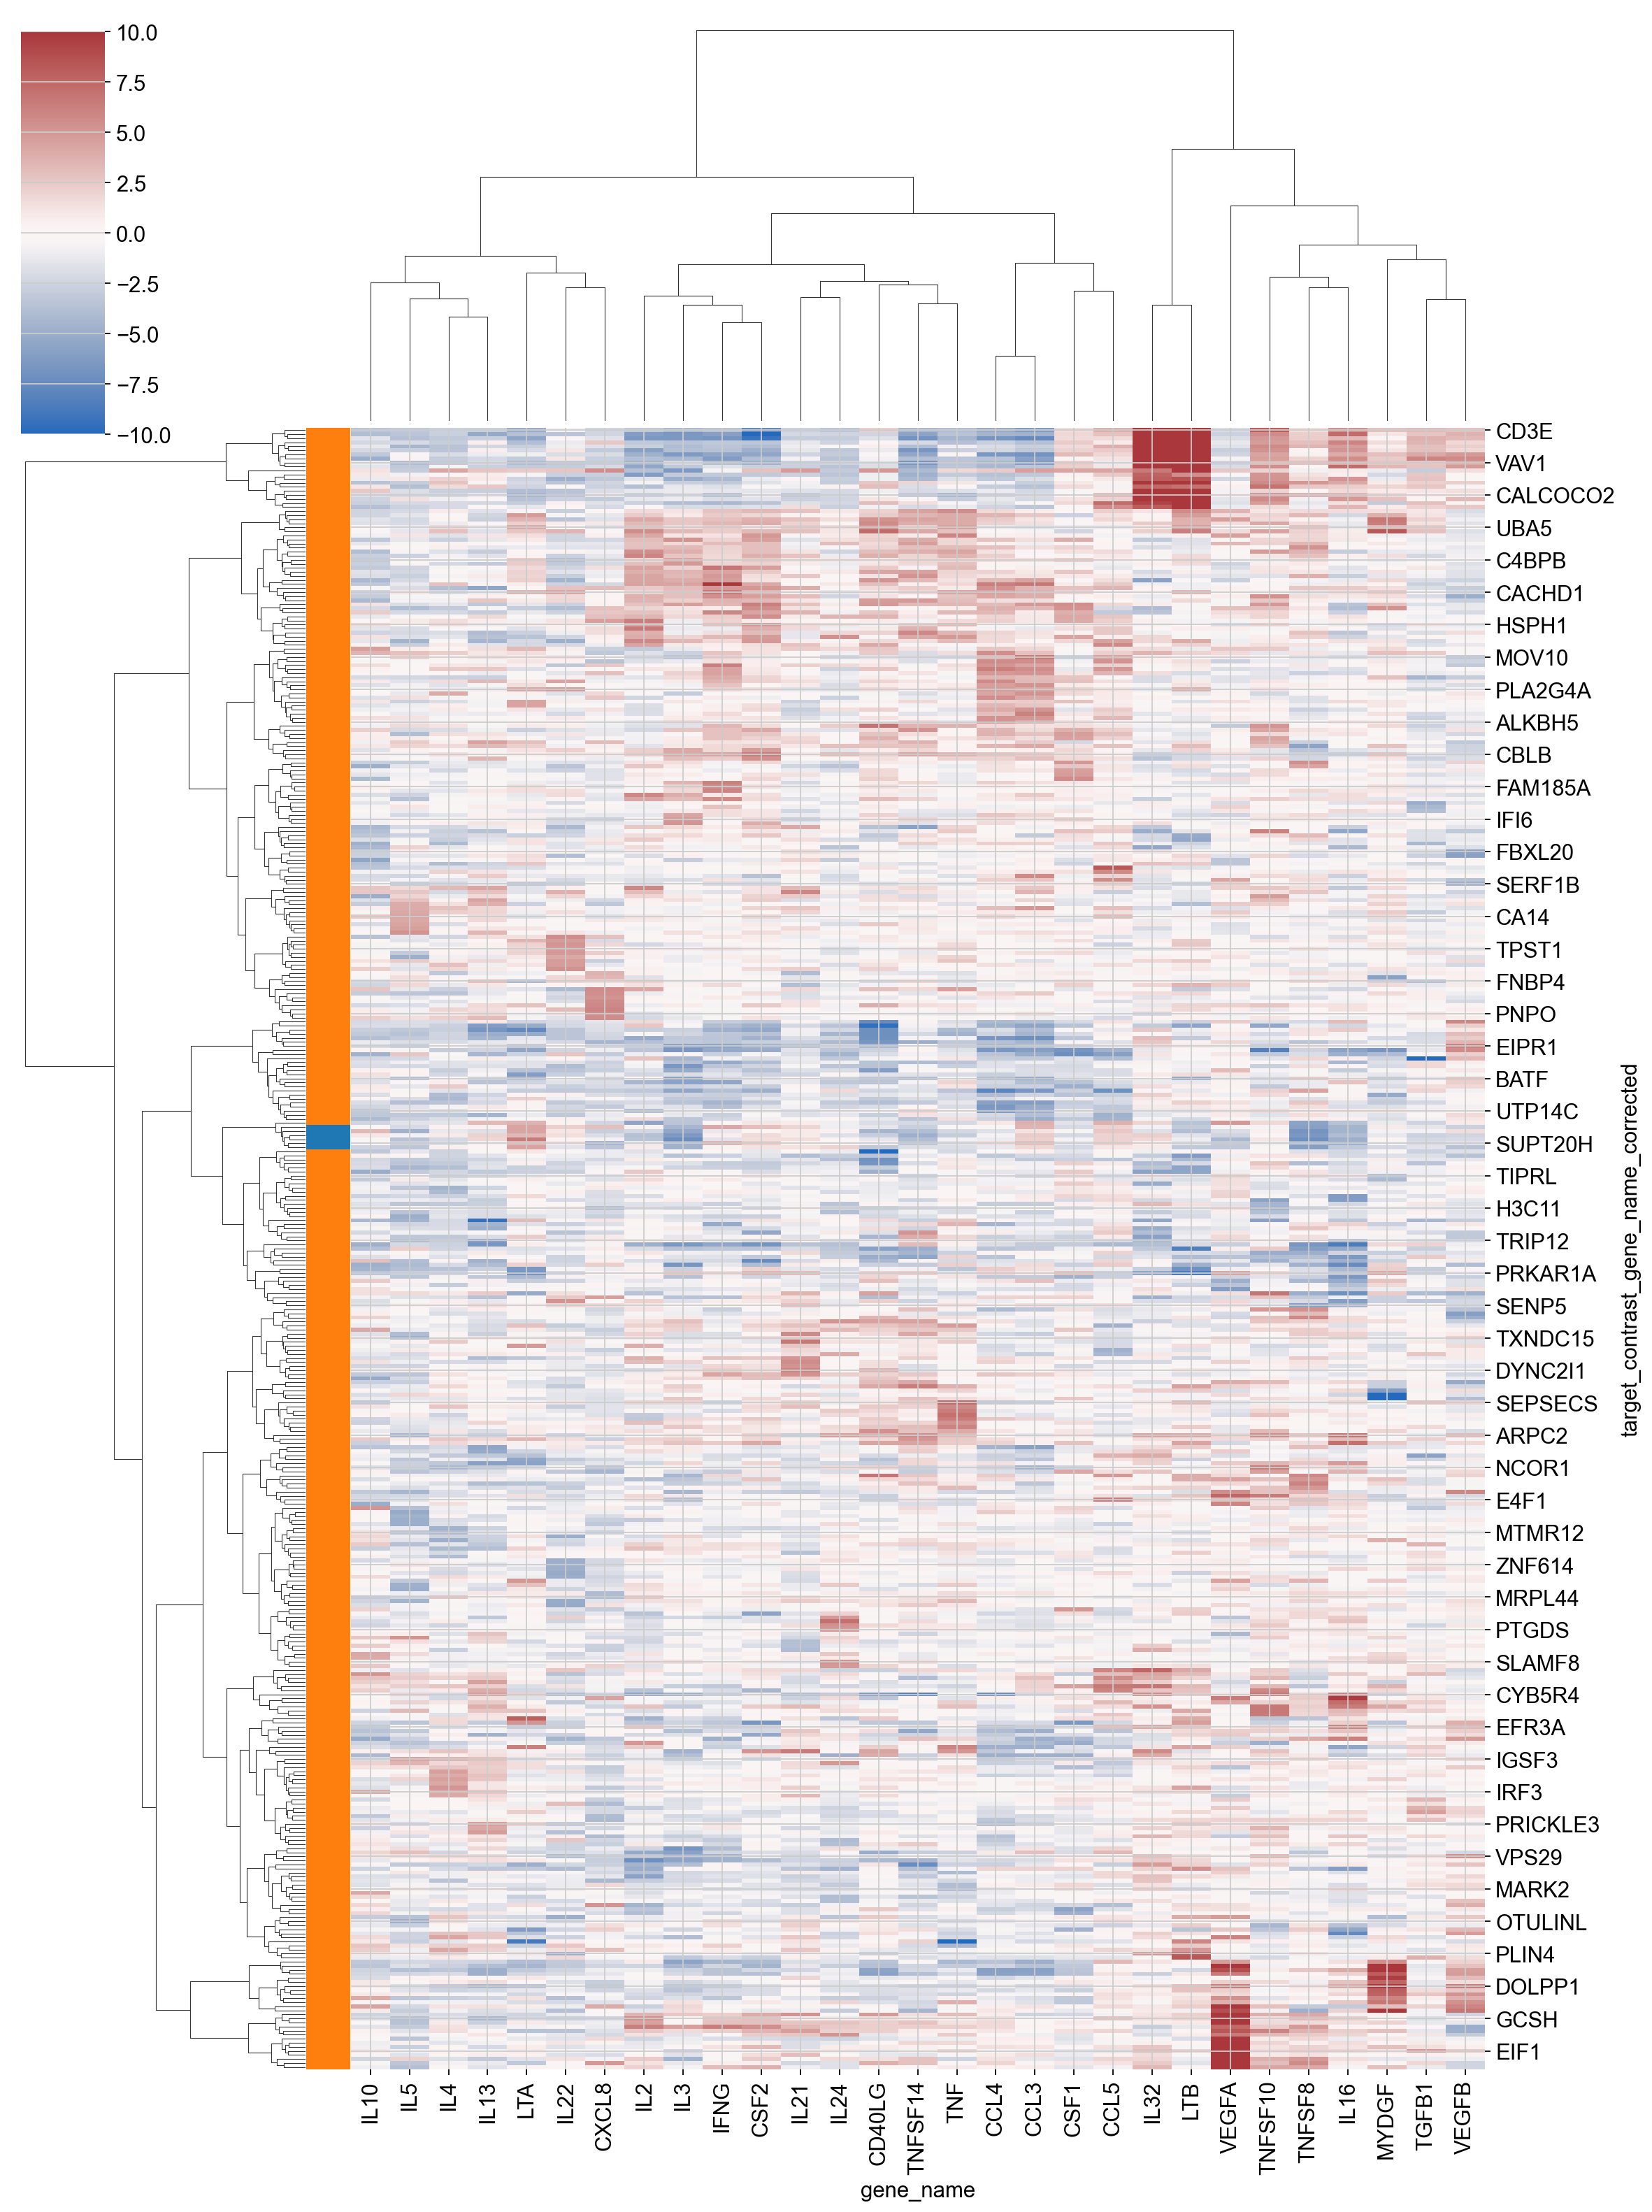

In [332]:
adata_scale = adata.copy()
#sc.pp.scale(adata_scale)
#genelist = ['MED12', 'MED24', 'MED1', 'MED13', 'MED19']
genelist = ['SGF29', 'TADA2B', 'TAF5L', 'TAF6L', 'TADA1','SUPT20H','SUPT7L']
#genelist = ['CD3G', 'CD28', 'PTPRC', 'ITK', 'LCP2']
#genelist = ['STAT3', 'KDM1A', 'FOXO1', 'TBX21']
#genelist = ['SMARCA4', 'SMARCB1', 'SMARCC1','SMARCE1']
#genelist = ['EIF1', 'ADAT2', 'ELP3', 'ELP2', 'CTU1', 'TRMT61A', 'ADAT3']
#genelist = ['DDRGK1', 'UFL1', 'UBA5', 'UFM1']
#genelist = ['RFT1', 'SLC35B1', 'MPI', 'SEC61B', 'PDIA6', 'UBE2G2', 'DOLPP1', 'SEC63', 'ALG6', 'PMM2']

# Create the new column
adata_scale.obs['highlight_group'] = 'Other'
adata_scale.obs.loc[adata_scale.obs['target_contrast_gene_name_corrected'].isin(genelist), 'highlight_group'] = 'Highlighted'
adata_scale.obs['highlight_group'] = adata_scale.obs['highlight_group'].astype('category')

# --- STEP 2: The updated clustermap command ---
sc.pl.clustermap(
    adata_scale,
    method = 'ward',
    obs_keys='highlight_group',
    vmin=-10,
    vmax=10,
    figsize=(15,20),
    cmap='vlag'
)

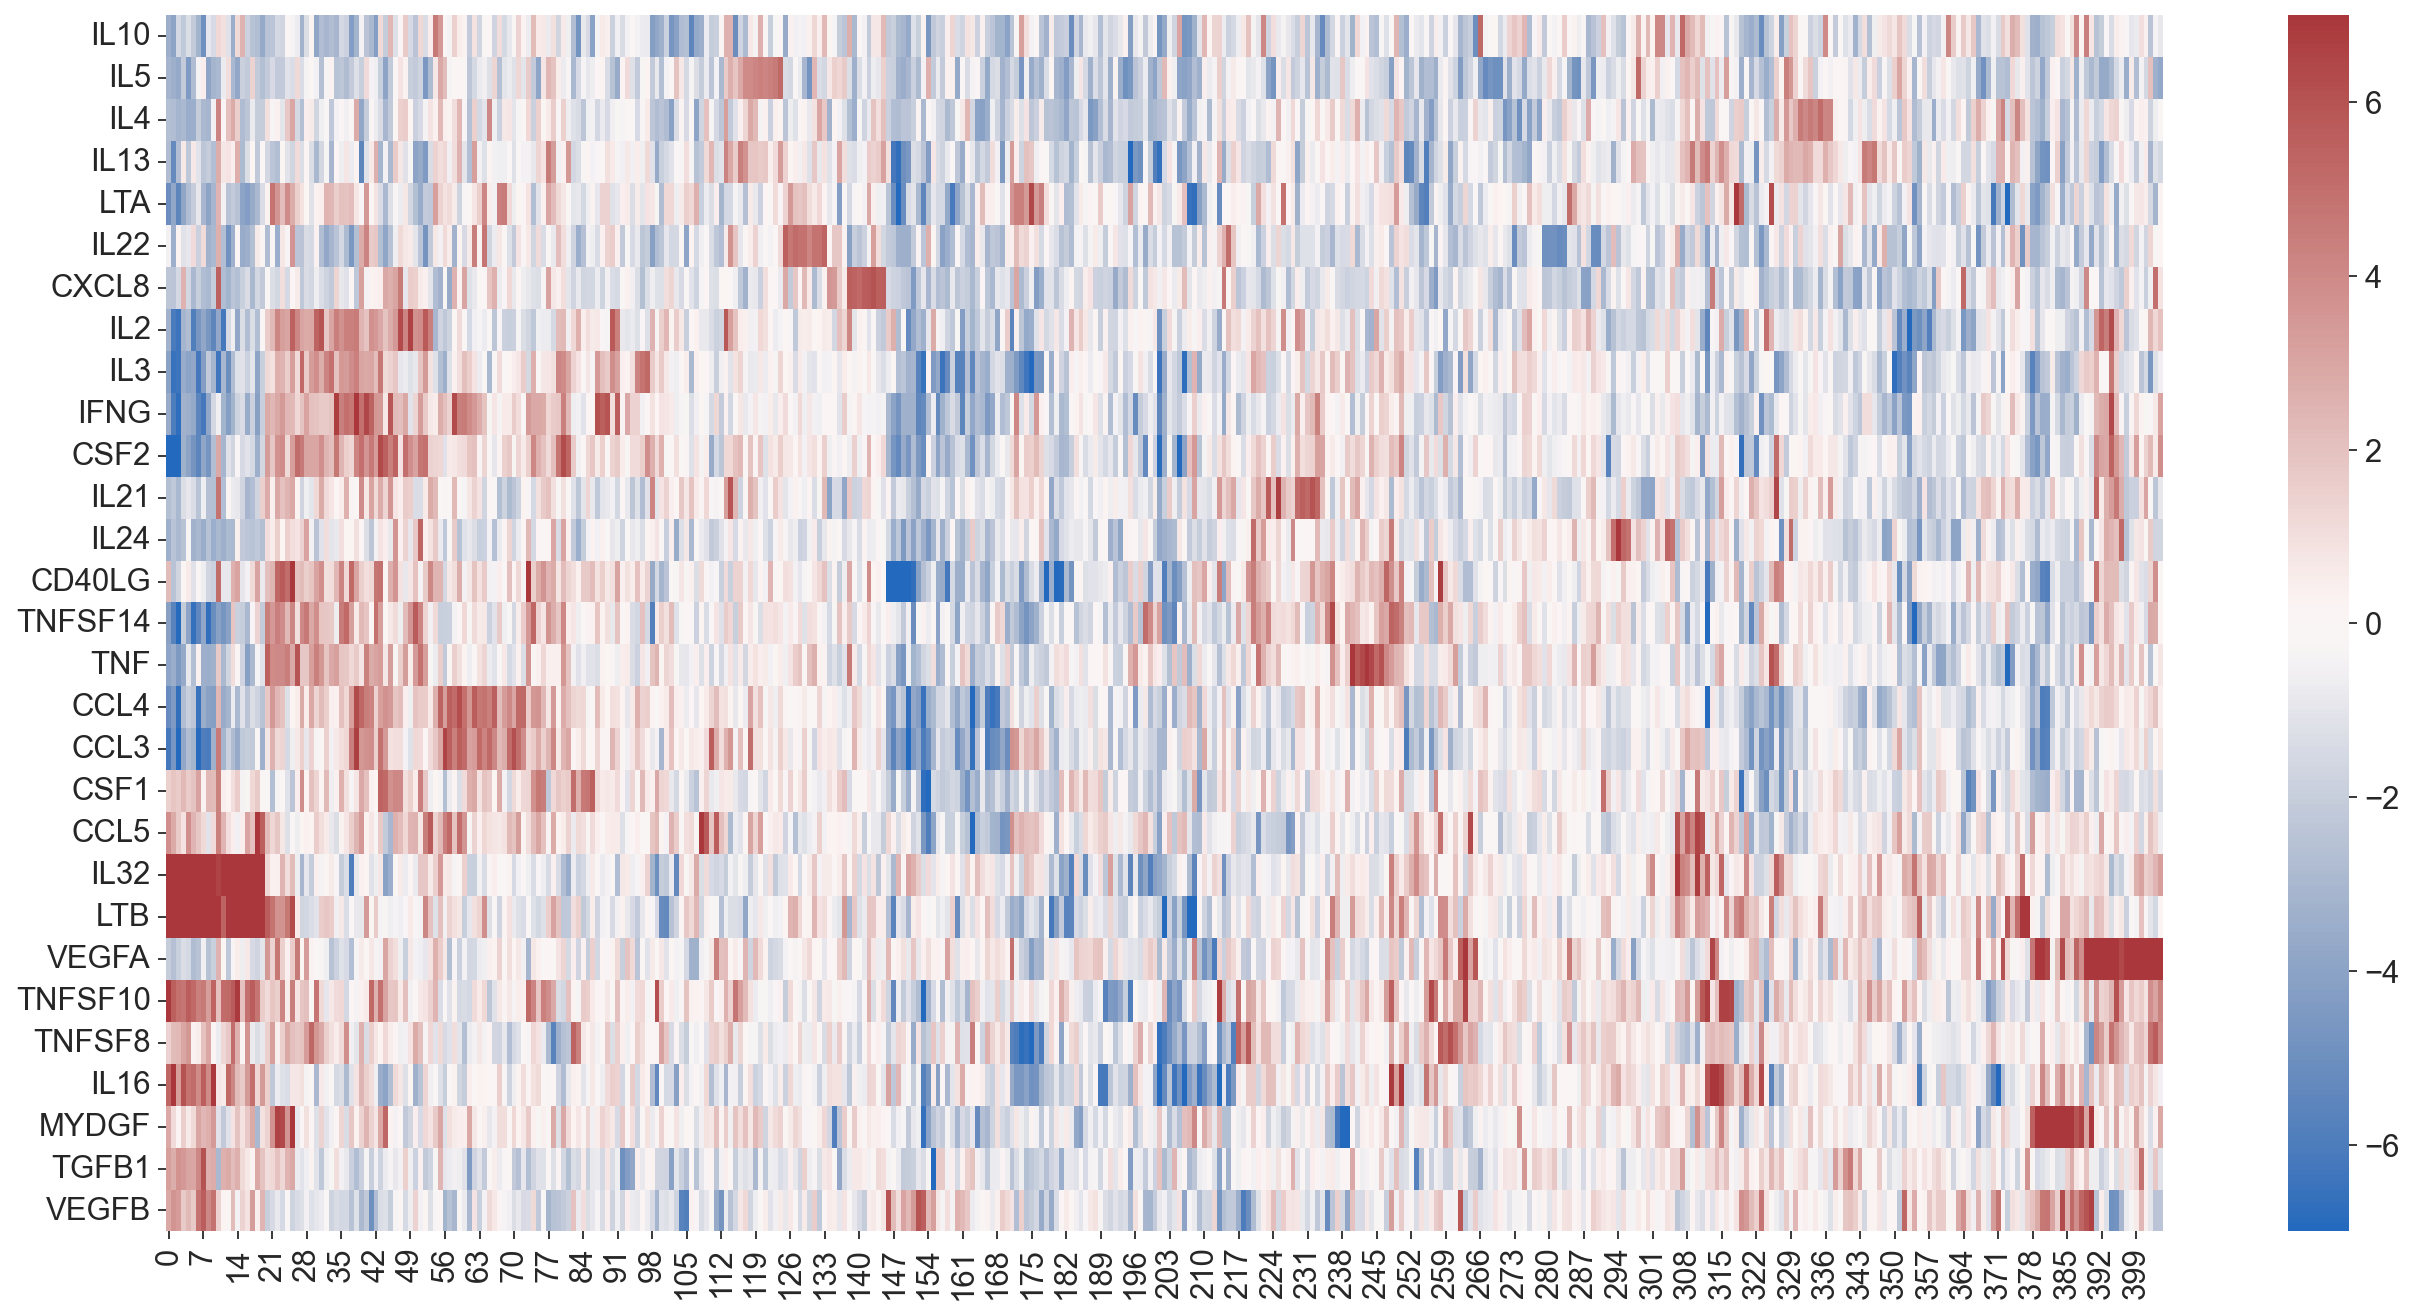

In [352]:
sns.set_style("ticks")
data_to_cluster = adata_scale.X.T
clustermap = sns.clustermap(data_to_cluster,
                            method='ward',
                            metric='euclidean')
xticklabel_indices = clustermap.dendrogram_col.reordered_ind
yticklabel_indices = clustermap.dendrogram_row.reordered_ind
plt.close(clustermap.fig)

reordered_data = data_to_cluster[np.ix_(yticklabel_indices, xticklabel_indices)]

reordered_row_labels = adata_scale.var_names[yticklabel_indices]
reordered_col_labels = adata_scale.obs_names[xticklabel_indices]

plt.figure(figsize=(20, 10)) # Adjust size based on your data dimensions

sns.heatmap(reordered_data,
            cmap='vlag',
            vmin=-7,
            vmax=7,
            yticklabels=reordered_row_labels)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.savefig('./results/cytokine_summary_quick_test.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

In [321]:
ZSCORE_THRESHOLD = 0
N_TOP = 10

# Assuming adata_cytokine and its layers/indices are already defined
zscore_df = pd.DataFrame(
    adata_cytokine.layers['masked_zscore'],
    index=adata_cytokine.obs_names,
    columns=adata_cytokine.var_names
)

selected_obs_indices = set()

for gene in zscore_df.columns:
    gene_zscores = zscore_df[gene]
    
    # 1. Filter for all observations that exceed the absolute Z-score threshold
    abs_zscore_filter = gene_zscores.abs() > ZSCORE_THRESHOLD
    
    # Get the subset of Z-scores that meet the threshold
    threshold_passing_scores = gene_zscores[abs_zscore_filter]
    
    # If no observations pass the threshold, skip to the next gene
    if threshold_passing_scores.empty:
        continue
        
    # 2. Select the N_TOP positive scores from the *threshold-passing* subset
    # This enforces the "AND" logic: (Zscore > ZSCORE_THRESHOLD) AND (is one of the top N)
    top_pos_passing = threshold_passing_scores[threshold_passing_scores > 0].nlargest(N_TOP)
    selected_obs_indices.update(top_pos_passing.index.tolist())

    # 3. Select the N_TOP negative scores from the *threshold-passing* subset
    # This enforces the "AND" logic: (Zscore < -ZSCORE_THRESHOLD) AND (is one of the top N)
    top_neg_passing = threshold_passing_scores[threshold_passing_scores < 0].nsmallest(N_TOP)
    selected_obs_indices.update(top_neg_passing.index.tolist())

selected_obs_list = list(selected_obs_indices)
len(selected_obs_list)

405

In [322]:
adata = adata_cytokine[selected_obs_list, :].copy()
adata.var_names = adata.var.gene_name.copy()
adata.obs_names = adata.obs.target_contrast_gene_name_corrected.copy()
adata_scale = adata.copy()
from scipy.cluster.hierarchy import linkage, leaves_list
# First, extract the subset of data used for clustering in the plot:
X = adata_scale.X

# Calculate the linkage matrix (Z)
Z = linkage(X, method='ward', metric='euclidean')

# 2. Get the row order from the linkage
#    'leaves_list' returns the original indices in the clustered order
ordered_indices = leaves_list(Z)

# 3. Use the ordered indices to retrieve the corresponding observation (row) names
ordered_row_names = adata_scale.obs_names[ordered_indices].tolist()

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/anndata/_core/anndata.py:842: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['CHD6', 'TMX1', 'PRRC2A', 'UGDH', 'PPP1R2']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")


In [357]:
#genelist = ['MED12', 'MED24', 'MED1', 'MED13', 'MED19']
genelist = ['SGF29', 'TADA2B', 'TAF5L', 'TAF6L', 'TADA1','SUPT20H','SUPT7L']
#genelist = ['CD3G', 'CD28', 'PTPRC', 'ITK', 'LCP2']
genelist = ['DDRGK1', 'UFL1', 'UBA5', 'UFM1']
genelist = ['EIF1', 'ADAT2', 'ELP3', 'ELP2', 'CTU1', 'TRMT61A', 'ADAT3']
genelist = ['RFT1', 'SLC35B1', 'MPI', 'PDIA6', 'UBE2G2', 'DOLPP1', 'ALG6', 'PMM2']
np.where(np.isin(np.array(ordered_row_names), genelist))

(array([378, 379, 380, 382, 383, 384, 387, 388]),)

In [350]:
print(ordered_row_names)

['CD3E', 'LCP2', 'CD3G', 'BCAT2', 'CD247', 'PLCG1', 'ZAP70', 'LAT', 'VAV1', 'CD3D', 'ATP2A2', 'TMX1', 'ITK', 'LCK', 'PTPRC', 'ZBED3', 'CALCOCO2', 'LRBA', 'SKIC2', 'PGGT1B', 'GTF3C6', 'ACAD11', 'DDRGK1', 'UFL1', 'UBA5', 'UFM1', 'EEF1G', 'GNPAT', 'ARFGEF1', 'NOC2L', 'DUSP12', 'POP4', 'C4BPB', 'ABCD2', 'UROD', 'PHOSPHO2', 'DNAJC2', 'ARNT', 'TFAP2C', 'CPSF6', 'CACHD1', 'NFKB2', 'PRPF39', 'EIF4G1', 'STK11', 'CMTR2', 'ATP1B3', 'TNIP2', 'HSPH1', 'DENND1A', 'RITA1', 'BUD23', 'MMAB', 'TESPA1', 'ING5', 'ATXN7L3', 'MOV10', 'ICOS', 'ZNF608', 'PPP1R2', 'RAMP3', 'CFAP298', 'ZIC4', 'DEK', 'PLA2G4A', 'NRM', 'PROZ', 'CAPN15', 'CACNA1C', 'SLC39A13', 'LONRF3', 'SLX1B', 'ALKBH5', 'TAF13', 'RNF31', 'UROS', 'MYG1', 'NRBP1', 'NCKAP1L', 'NIPBL', 'CBLB', 'ARIH1', 'ZWINT', 'ERCC4', 'ERG', 'CFAP36', 'HNRNPR', 'MOAP1', 'FAM185A', 'FLT4', 'LRRC58', 'OTUD1', 'B9D2', 'TRMT10A', 'RBPJ', 'FIRRM', 'IFI6', 'GALR2', 'PPCS', 'ATXN10', 'C9orf78', 'PCBP1', 'COX6B1', 'IPO9', 'FBXL20', 'DNAJC4', 'WBP1L', 'GLI1', 'LILRB1', 'ES

In [731]:
nde_thres = 75
mask = (de_summary_stats.n_total_de_genes>nde_thres) & (de_summary_stats.condition=='Stim8hr')
strong_gene_list = de_summary_stats[mask].target_name_corrected

In [732]:
mask = (adata_cytokine.layers['adj_p_value']<0.2).any(axis=1) & (adata_cytokine.obs.target_contrast_gene_name_corrected.isin(strong_gene_list))
adata = adata_cytokine[mask].copy()

In [733]:
adata

AnnData object with n_obs × n_vars = 1120 × 29
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'masked_zscore', 'p_value', 'zscore'

In [759]:
adata.X = adata.layers['masked_zscore'].copy()
#sc.pp.scale(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.leiden(adata, resolution=1.5, key_added='leiden_clusters')
adata.obs.leiden_clusters = adata.obs.leiden_clusters.astype('int')
adata.obs.leiden_clusters = adata.obs.leiden_clusters.astype('category')

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


In [760]:
adata.obs.leiden_clusters

ENSG00000104368_Stim8hr    15
ENSG00000128607_Stim8hr     5
ENSG00000163600_Stim8hr     1
ENSG00000174177_Stim8hr     6
ENSG00000138074_Stim8hr     9
                           ..
ENSG00000163848_Stim8hr    12
ENSG00000089195_Stim8hr     6
ENSG00000100201_Stim8hr     0
ENSG00000152382_Stim8hr    14
ENSG00000171105_Stim8hr    14
Name: leiden_clusters, Length: 1120, dtype: category
Categories (17, int64): [0, 1, 2, 3, ..., 13, 14, 15, 16]

In [774]:
genelist = ['CD3G', 'CD28', 'PTPRC', 'ATP2A2', 'MEN1', 'MED24', 'MED12', 'TADA1', 'SGF29', 
            'NFKB2', 'KDM1A', 'CYB5R4','CCNC','PTEN','USP22','GATA3','IL4R','STAT6','SMARCB1',
           'ELOB','STAT5B','RASA2','STAT3','CHD4','ICOS','PTPN2','IL2RB','TSC1','TSC2','MTOR','RASGRP1','TBX21']

In [762]:
adata[adata.obs.target_contrast_gene_name_corrected.isin(genelist)].obs.sort_values('target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000174437_Stim8hr                    ATP2A2           Stim8hr   
ENSG00000112237_Stim8hr                      CCNC           Stim8hr   
ENSG00000178562_Stim8hr                      CD28           Stim8hr   
ENSG00000160654_Stim8hr                      CD3G           Stim8hr   
ENSG00000111642_Stim8hr                      CHD4           Stim8hr   
ENSG00000065615_Stim8hr                    CYB5R4           Stim8hr   
ENSG00000103363_Stim8hr                      ELOB           Stim8hr   
ENSG00000107485_Stim8hr                     GATA3           Stim8hr   
ENSG00000163600_Stim8hr                      ICOS           Stim8hr   
ENSG00000100385_Stim8hr                     IL2RB           Stim8hr   
ENSG00000077238_Stim8hr                      IL4R           Stim8hr   
ENSG00000004487_Stim8hr                     KDM1A           Stim8hr   
ENSG00000184634_Stim8hr                     MED12           Stim8hr   
ENSG00000008838_Stim8hr                     MED24           Stim8hr   
ENSG00000133895_Stim8hr                      MEN1           Stim8hr   
ENSG00000198793_Stim8hr                      MTOR           Stim8hr   
ENSG00000077150_Stim8hr                     NFKB2           Stim8hr   
ENSG00000171862_Stim8hr                      PTEN           Stim8hr   
ENSG00000175354_Stim8hr                     PTPN2           Stim8hr   
ENSG00000081237_Stim8hr                     PTPRC           Stim8hr   
ENSG00000155903_Stim8hr                     RASA2           Stim8hr   
ENSG00000172575_Stim8hr                   RASGRP1           Stim8hr   
ENSG00000176476_Stim8hr                     SGF29           Stim8hr   
ENSG00000099956_Stim8hr                   SMARCB1           Stim8hr   
ENSG00000168610_Stim8hr                     STAT3           Stim8hr   
ENSG00000173757_Stim8hr                    STAT5B           Stim8hr   
ENSG00000166888_Stim8hr                     STAT6           Stim8hr   
ENSG00000152382_Stim8hr                     TADA1           Stim8hr   
ENSG00000165699_Stim8hr                      TSC1           Stim8hr   
ENSG00000103197_Stim8hr                      TSC2           Stim8hr   
ENSG00000124422_Stim8hr                     USP22           Stim8hr   

                         target_contrast chunk  n_cells_target  \
ENSG00000174437_Stim8hr  ENSG00000174437   574           248.0   
ENSG00000112237_Stim8hr  ENSG00000112237   385          3668.0   
ENSG00000178562_Stim8hr  ENSG00000178562    99           675.0   
ENSG00000160654_Stim8hr  ENSG00000160654   274           230.0   
ENSG00000111642_Stim8hr  ENSG00000111642   209           246.0   
ENSG00000065615_Stim8hr  ENSG00000065615   426           211.0   
ENSG00000103363_Stim8hr  ENSG00000103363    44          1093.0   
ENSG00000107485_Stim8hr  ENSG00000107485    77           818.0   
ENSG00000163600_Stim8hr  ENSG00000163600     0           658.0   
ENSG00000100385_Stim8hr  ENSG00000100385    76            75.0   
ENSG00000077238_Stim8hr  ENSG00000077238   222           903.0   
ENSG00000004487_Stim8hr  ENSG00000004487   447           541.0   
ENSG00000184634_Stim8hr  ENSG00000184634   523           219.0   
ENSG00000008838_Stim8hr  ENSG00000008838   257           700.0   
ENSG00000133895_Stim8hr  ENSG00000133895   120           189.0   
ENSG00000198793_Stim8hr  ENSG00000198793   557            46.0   
ENSG00000077150_Stim8hr  ENSG00000077150   395          2152.0   
ENSG00000171862_Stim8hr  ENSG00000171862   144          1529.0   
ENSG00000175354_Stim8hr  ENSG00000175354   395           278.0   
ENSG00000081237_Stim8hr  ENSG00000081237   115           355.0   
ENSG00000155903_Stim8hr  ENSG00000155903   385           471.0   
ENSG00000172575_Stim8hr  ENSG00000172575   311           449.0   
ENSG00000176476_Stim8hr  ENSG00000176476   626          1062.0   
ENSG00000099956_Stim8hr  ENSG00000099956   651           258.0   
ENSG00000168610_Stim8hr  ENSG00000168610   536           255.0   
ENSG00000173757_Stim8hr  ENSG000001

In [763]:
mask = (adata_cytokine.layers['adj_p_value']<0.2).any(axis=1) & (adata_cytokine.obs.target_contrast_gene_name_corrected.isin(strong_gene_list))
adata_downstream = adata_cytokine[mask].copy().T

In [764]:
adata_downstream

AnnData object with n_obs × n_vars = 29 × 1120
    obs: 'gene_ids', 'gene_name'
    var: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'masked_zscore', 'p_value', 'zscore'

In [765]:
adata_downstream.X = adata_downstream.layers['masked_zscore'].copy()
#sc.pp.scale(adata_downstream)
sc.pp.neighbors(adata_downstream, n_neighbors=15, use_rep='X')
sc.tl.leiden(adata_downstream, resolution=1.5, key_added='leiden_clusters')
adata_downstream.obs.leiden_clusters = adata_downstream.obs.leiden_clusters.astype('int')
adata_downstream.obs.leiden_clusters = adata_downstream.obs.leiden_clusters.astype('category')

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


In [766]:
adata_downstream.obs.leiden_clusters.unique()

[0, 3, 1, 2, 4]
Categories (5, int64): [0, 1, 2, 3, 4]

In [767]:
adata_downstream.obs.sort_values('leiden_clusters')

gene_ids gene_name leiden_clusters
ENSG00000008517  ENSG00000008517      IL32               0
ENSG00000172349  ENSG00000172349      IL16               0
ENSG00000105329  ENSG00000105329     TGFB1               0
ENSG00000106952  ENSG00000106952    TNFSF8               0
ENSG00000227507  ENSG00000227507       LTB               0
ENSG00000112715  ENSG00000112715     VEGFA               0
ENSG00000173511  ENSG00000173511     VEGFB               0
ENSG00000121858  ENSG00000121858   TNFSF10               0
ENSG00000164400  ENSG00000164400      CSF2               1
ENSG00000164399  ENSG00000164399       IL3               1
ENSG00000232810  ENSG00000232810       TNF               1
ENSG00000125735  ENSG00000125735   TNFSF14               1
ENSG00000111537  ENSG00000111537      IFNG               1
ENSG00000109471  ENSG00000109471       IL2               1
ENSG00000102245  ENSG00000102245    CD40LG               1
ENSG00000127318  ENSG00000127318      IL22               2
ENSG00000136634  ENSG00000136634      IL10               2
ENSG00000113520  ENSG00000113520       IL4               2
ENSG00000169194  ENSG00000169194      IL13               2
ENSG00000169429  ENSG00000169429     CXCL8               2
ENSG00000113525  ENSG00000113525       IL5               2
ENSG00000226979  ENSG00000226979       LTA               2
ENSG00000271503  ENSG00000271503      CCL5               3
ENSG00000277632  ENSG00000277632      CCL3               3
ENSG00000275302  ENSG00000275302      CCL4               3
ENSG00000074842  ENSG00000074842     MYDGF               3
ENSG00000184371  ENSG00000184371      CSF1               3
ENSG00000162892  ENSG00000162892      IL24               4
ENSG00000138684  ENSG00000138684      IL21               4

In [724]:
de_summary_stats[de_summary_stats.target_name_corrected=='IL16']

target_contrast target_name condition  n_cells_target  n_up_genes  \
11428  ENSG00000172349        IL16      Rest           725.0           1   
23924  ENSG00000172349        IL16  Stim48hr           705.0           0   
33874  ENSG00000172349        IL16   Stim8hr           633.0           0   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
11428             1                 2            -15.172579   
23924             1                 1            -15.801369   
33874             1                 1            -13.676965   

       ontarget_significant    baseMean  offtarget_flag  \
11428                  True  153.145181           False   
23924                  True  126.596422           False   
33874                  True  142.379306           False   

      n_total_genes_category ontarget_effect_category  \
11428          2-10 DE genes             on-target KD   
23924              1 DE gene             on-target KD   
33874              1 DE gene             on-target KD   

      target_contrast_corrected                 obs_names  \
11428           ENSG00000172349      ENSG00000172349_Rest   
23924           ENSG00000172349  ENSG00000172349_Stim48hr   
33874           ENSG00000172349   ENSG00000172349_Stim8hr   

      target_name_corrected  
11428                  IL16  
23924                  IL16  
33874                  IL16

In [768]:
adata_all = adata.copy()
adata_all.var = adata_downstream.obs.copy()
adata_all.var_names = adata_all.var.gene_name.copy()

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_27693/4239852042.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('leiden_clusters')
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_27693/4239852042.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.index.tolist())
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:2074: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData

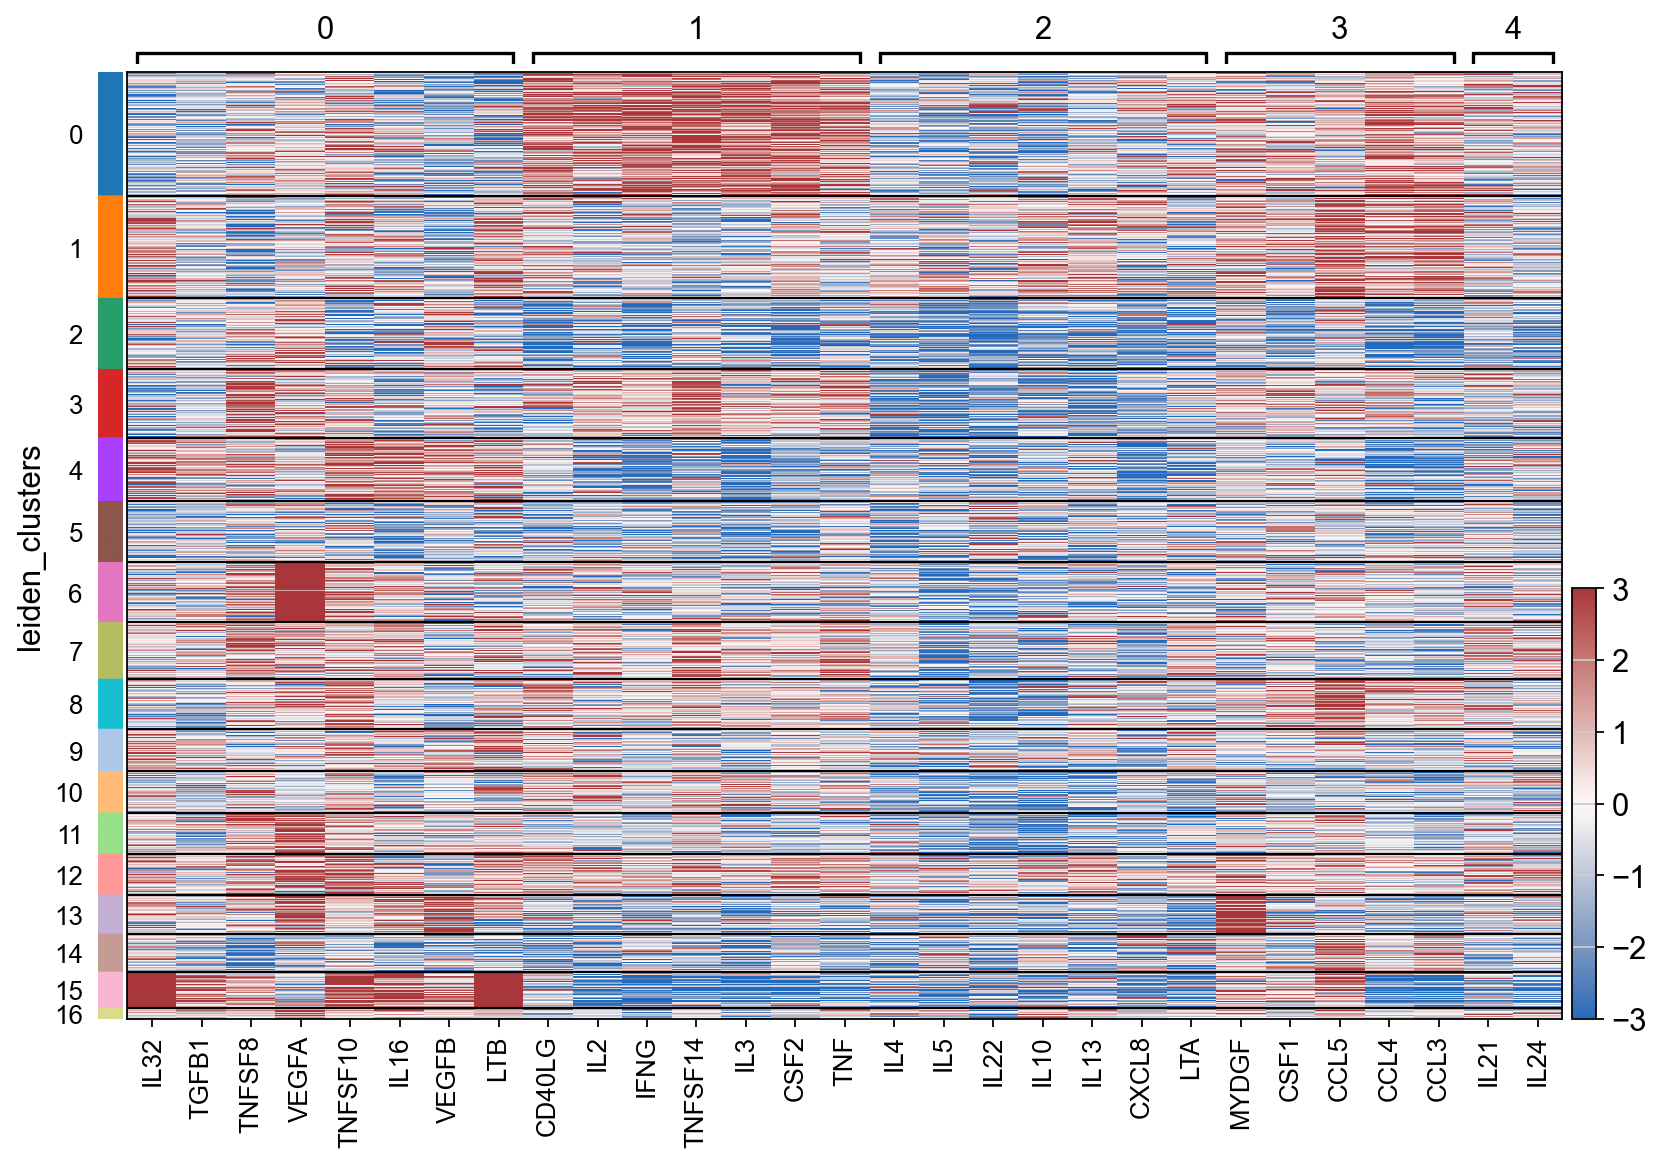

In [769]:
var_group_dict = (
    adata_all.var
    .groupby('leiden_clusters')
    .apply(lambda x: x.index.tolist())
    .to_dict()
)

sc.pl.heatmap(
    adata_all,
    var_names=var_group_dict,     # Passing the dict creates the top column legends
    groupby='leiden_clusters',    # Creates the left row legends
    layer='masked_zscore',
    vmin=-3,
    vmax=3,
    cmap='vlag',
    figsize=(12, 8),              # Increased width slightly to accommodate labels
    var_group_rotation=0          # Keeps column group labels horizontal (optional)
)

In [566]:
adata_all = adata.copy()
adata_all.var = adata_downstream.obs.copy()
adata_all.var_names = adata_all.var.gene_name.copy()

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_27693/965315898.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cluster_id, group_data in cluster_series.groupby(cluster_series, sort=False):


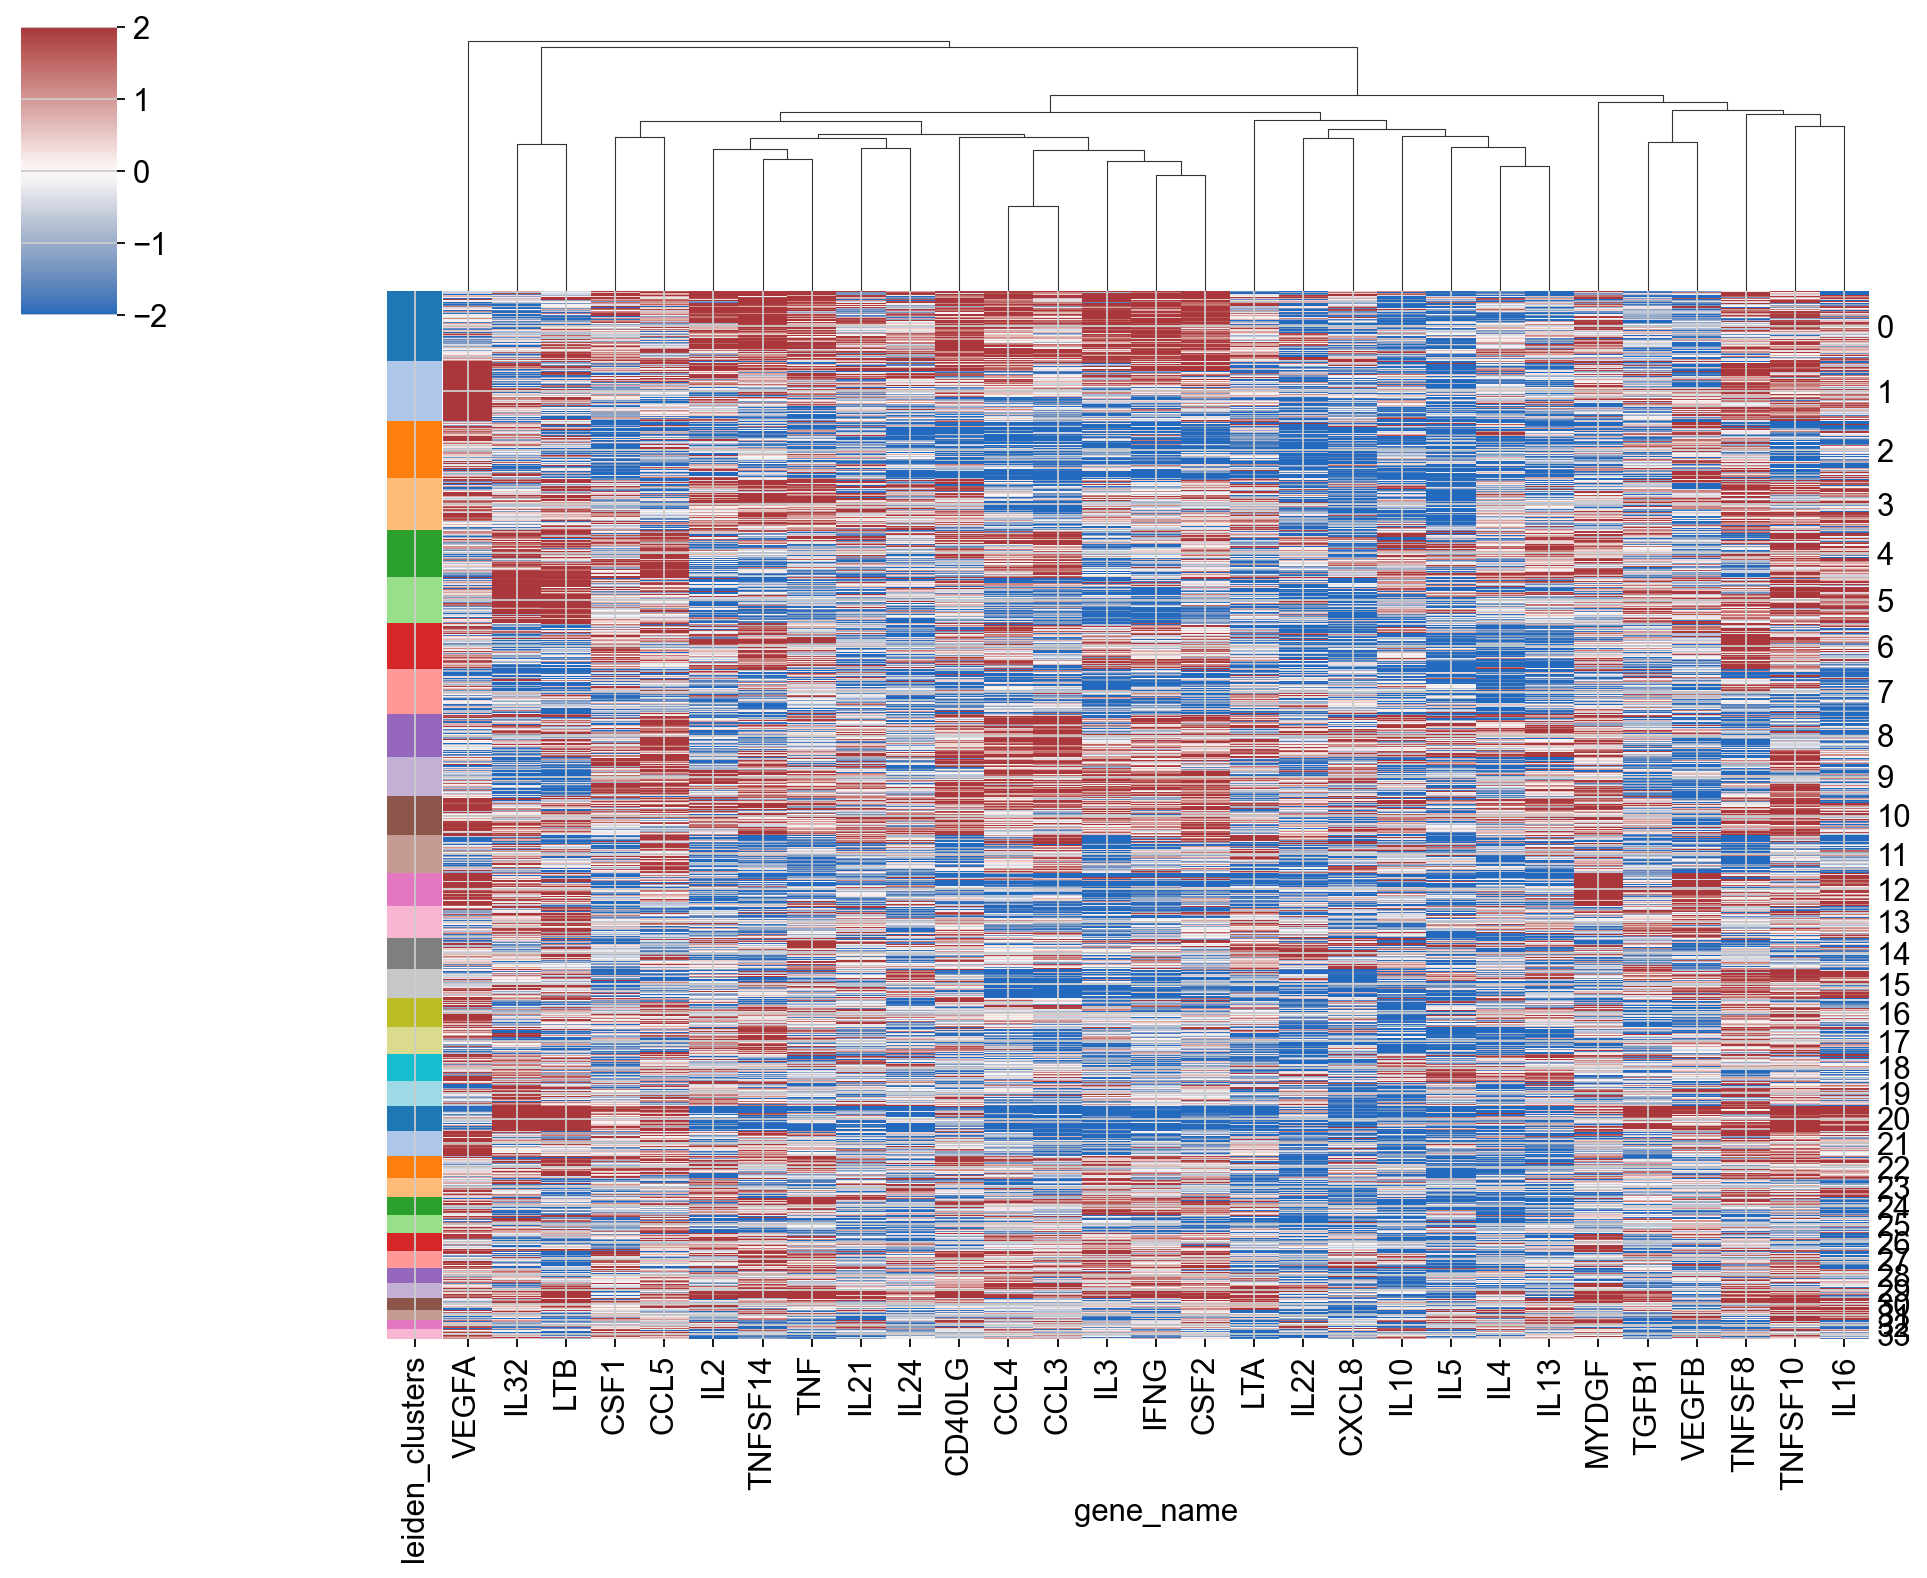

In [569]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.cluster.hierarchy as sch
from scipy.spatial import distance

# --- STEP 1: Perform "Stratified" Clustering ---
# We calculate the dendrogram for each cluster individually and concatenate the indices.

sorted_indices = []

# Get the unique clusters (sorted numerically/alphabetically)
clusters = adata_all.obs['leiden_clusters'].unique().sort_values()

for cluster_id in clusters:
    # 1. Extract the subset of data for this specific cluster
    # Note: We use the layer data directly to ensure we cluster on the correct values
    cells_in_cluster = adata_all.obs[adata_all.obs['leiden_clusters'] == cluster_id].index
    sub_data = adata_all[cells_in_cluster, :].layers['masked_zscore']
    
    # 2. If cluster has > 1 cell, perform hierarchical clustering
    if len(cells_in_cluster) > 1:
        # Calculate distance and linkage matrix
        # 'metric' and 'method' should match what you want (e.g., euclidean/average)
        d = distance.pdist(sub_data, metric='euclidean')
        L = sch.linkage(d, method='average')
        
        # Get the leaf ordering (the indices of the sorted rows)
        leaves = sch.leaves_list(L)
        
        # Reorder the original indices for this block using the leaves
        sorted_indices.extend(cells_in_cluster[leaves])
    else:
        # If only 1 cell, just append it
        sorted_indices.extend(cells_in_cluster)

# --- STEP 2: Reorder Data & Prepare Plotting ---

# Create a DataFrame ordered by our new "Stratified" list
adata_stratified = adata_all[sorted_indices, :]
df_data = pd.DataFrame(
    adata_stratified.layers['masked_zscore'],
    index=adata_stratified.obs_names,
    columns=adata_stratified.var_names
)

# Create the Row Colors (for the side bar)
cluster_series = adata_stratified.obs['leiden_clusters']
unique_clusters = cluster_series.unique()
palette = sns.color_palette("tab20", n_colors=len(unique_clusters))
lut = dict(zip(unique_clusters, palette))

# Fix for Pandas Series/Tuples
row_colors = pd.Series(
    [lut[c] for c in cluster_series], 
    index=cluster_series.index, 
    name='leiden_clusters'
)

# --- STEP 3: Plot the Clustermap ---

g = sns.clustermap(
    df_data,
    row_cluster=False,      # CRITICAL: We already clustered the rows manually!
    col_cluster=True,       # Let Seaborn cluster the columns (genes) normally
    row_colors=row_colors,  # Add the side color bar
    cmap='vlag',
    vmin=-2, vmax=2,
    yticklabels=False,
    xticklabels=True,
    figsize=(12, 10)
)

# --- STEP 4: Add Y-Axis Labels (Centered) ---

# Calculate center positions for labels
# Since the data is perfectly sorted by cluster blocks, we can just iterate the series
ticks = []
labels = []
current_pos = 0

for cluster_id, group_data in cluster_series.groupby(cluster_series, sort=False):
    n_cells = len(group_data)
    center_pos = current_pos + (n_cells / 2)
    ticks.append(center_pos)
    labels.append(cluster_id)
    current_pos += n_cells

# Apply ticks
g.ax_heatmap.set_yticks(ticks)
g.ax_heatmap.set_yticklabels(labels)
g.ax_heatmap.tick_params(axis='y', length=0, rotation=0)

# Remove the legend (redundant now)
if g.ax_col_dendrogram.legend_:
    g.ax_col_dendrogram.legend_.remove()

plt.show()

In [ ]:
adata_all[adata_all.obs.leiden_clusters==7].obs.sort_values('target_contrast_gene_name_corrected')

In [775]:
adata_all[adata_all.obs.target_contrast_gene_name_corrected.isin(genelist)].obs.sort_values('target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000174437_Stim8hr                    ATP2A2           Stim8hr   
ENSG00000112237_Stim8hr                      CCNC           Stim8hr   
ENSG00000178562_Stim8hr                      CD28           Stim8hr   
ENSG00000160654_Stim8hr                      CD3G           Stim8hr   
ENSG00000111642_Stim8hr                      CHD4           Stim8hr   
ENSG00000065615_Stim8hr                    CYB5R4           Stim8hr   
ENSG00000103363_Stim8hr                      ELOB           Stim8hr   
ENSG00000107485_Stim8hr                     GATA3           Stim8hr   
ENSG00000163600_Stim8hr                      ICOS           Stim8hr   
ENSG00000100385_Stim8hr                     IL2RB           Stim8hr   
ENSG00000077238_Stim8hr                      IL4R           Stim8hr   
ENSG00000004487_Stim8hr                     KDM1A           Stim8hr   
ENSG00000184634_Stim8hr                     MED12           Stim8hr   
ENSG00000008838_Stim8hr                     MED24           Stim8hr   
ENSG00000133895_Stim8hr                      MEN1           Stim8hr   
ENSG00000198793_Stim8hr                      MTOR           Stim8hr   
ENSG00000077150_Stim8hr                     NFKB2           Stim8hr   
ENSG00000171862_Stim8hr                      PTEN           Stim8hr   
ENSG00000175354_Stim8hr                     PTPN2           Stim8hr   
ENSG00000081237_Stim8hr                     PTPRC           Stim8hr   
ENSG00000155903_Stim8hr                     RASA2           Stim8hr   
ENSG00000172575_Stim8hr                   RASGRP1           Stim8hr   
ENSG00000176476_Stim8hr                     SGF29           Stim8hr   
ENSG00000099956_Stim8hr                   SMARCB1           Stim8hr   
ENSG00000168610_Stim8hr                     STAT3           Stim8hr   
ENSG00000173757_Stim8hr                    STAT5B           Stim8hr   
ENSG00000166888_Stim8hr                     STAT6           Stim8hr   
ENSG00000152382_Stim8hr                     TADA1           Stim8hr   
ENSG00000073861_Stim8hr                     TBX21           Stim8hr   
ENSG00000165699_Stim8hr                      TSC1           Stim8hr   
ENSG00000103197_Stim8hr                      TSC2           Stim8hr   
ENSG00000124422_Stim8hr                     USP22           Stim8hr   

                         target_contrast chunk  n_cells_target  \
ENSG00000174437_Stim8hr  ENSG00000174437   574           248.0   
ENSG00000112237_Stim8hr  ENSG00000112237   385          3668.0   
ENSG00000178562_Stim8hr  ENSG00000178562    99           675.0   
ENSG00000160654_Stim8hr  ENSG00000160654   274           230.0   
ENSG00000111642_Stim8hr  ENSG00000111642   209           246.0   
ENSG00000065615_Stim8hr  ENSG00000065615   426           211.0   
ENSG00000103363_Stim8hr  ENSG00000103363    44          1093.0   
ENSG00000107485_Stim8hr  ENSG00000107485    77           818.0   
ENSG00000163600_Stim8hr  ENSG00000163600     0           658.0   
ENSG00000100385_Stim8hr  ENSG00000100385    76            75.0   
ENSG00000077238_Stim8hr  ENSG00000077238   222           903.0   
ENSG00000004487_Stim8hr  ENSG00000004487   447           541.0   
ENSG00000184634_Stim8hr  ENSG00000184634   523           219.0   
ENSG00000008838_Stim8hr  ENSG00000008838   257           700.0   
ENSG00000133895_Stim8hr  ENSG00000133895   120           189.0   
ENSG00000198793_Stim8hr  ENSG00000198793   557            46.0   
ENSG00000077150_Stim8hr  ENSG00000077150   395          2152.0   
ENSG00000171862_Stim8hr  ENSG00000171862   144          1529.0   
ENSG00000175354_Stim8hr  ENSG00000175354   395           278.0   
ENSG00000081237_Stim8hr  ENSG00000081237   115           355.0   
ENSG00000155903_Stim8hr  ENSG00000155903   385           471.0   
ENSG00000172575_Stim8hr  ENSG00000172575   311           449.0   
ENSG00000176476_Stim8hr  ENSG00000176476   626          1062.0   
ENSG00000099956_Stim8hr  ENSG00000099956   651           258.0   
ENSG00000168610_Stim8hr  ENSG0

In [ ]:
adata_all[adata_all.obs.leiden_clusters==13, adata_all.var.gene_name=='IL10'].obs

In [ ]:
pd.DataFrame(adata_all[adata_all.obs.leiden_clusters==13, adata_all.var.gene_name=='IL10'].layers['masked_zscore'],
            index=adata_all[adata_all.obs.leiden_clusters==13, adata_all.var.gene_name=='IL10'].obs.target_contrast_gene_name_corrected)

In [773]:
adata_downstream.obs.sort_values('leiden_clusters')

gene_ids gene_name leiden_clusters
ENSG00000008517  ENSG00000008517      IL32               0
ENSG00000172349  ENSG00000172349      IL16               0
ENSG00000105329  ENSG00000105329     TGFB1               0
ENSG00000106952  ENSG00000106952    TNFSF8               0
ENSG00000227507  ENSG00000227507       LTB               0
ENSG00000112715  ENSG00000112715     VEGFA               0
ENSG00000173511  ENSG00000173511     VEGFB               0
ENSG00000121858  ENSG00000121858   TNFSF10               0
ENSG00000164400  ENSG00000164400      CSF2               1
ENSG00000164399  ENSG00000164399       IL3               1
ENSG00000232810  ENSG00000232810       TNF               1
ENSG00000125735  ENSG00000125735   TNFSF14               1
ENSG00000111537  ENSG00000111537      IFNG               1
ENSG00000109471  ENSG00000109471       IL2               1
ENSG00000102245  ENSG00000102245    CD40LG               1
ENSG00000127318  ENSG00000127318      IL22               2
ENSG00000136634  ENSG00000136634      IL10               2
ENSG00000113520  ENSG00000113520       IL4               2
ENSG00000169194  ENSG00000169194      IL13               2
ENSG00000169429  ENSG00000169429     CXCL8               2
ENSG00000113525  ENSG00000113525       IL5               2
ENSG00000226979  ENSG00000226979       LTA               2
ENSG00000271503  ENSG00000271503      CCL5               3
ENSG00000277632  ENSG00000277632      CCL3               3
ENSG00000275302  ENSG00000275302      CCL4               3
ENSG00000074842  ENSG00000074842     MYDGF               3
ENSG00000184371  ENSG00000184371      CSF1               3
ENSG00000162892  ENSG00000162892      IL24               4
ENSG00000138684  ENSG00000138684      IL21               4

In [770]:
adata_all = adata.copy()
adata_all.var = adata_downstream.obs.copy()
adata_all.var_names = adata_all.var.gene_name.copy()
perturbation_downstream_df = pd.DataFrame(data=None, 
                                          index=adata_all.obs.leiden_clusters.unique().sort_values(),
                                          columns=adata_all.var.leiden_clusters.unique().sort_values())
for i in perturbation_downstream_df.index:
    for j in perturbation_downstream_df.columns:
        perturbation_downstream_df.loc[i,j] = adata_all[adata_all.obs.leiden_clusters==i, adata_all.var.leiden_clusters==j].layers['masked_zscore'].mean().item()

perturbation_downstream_df = perturbation_downstream_df.astype(float)

<Axes: >

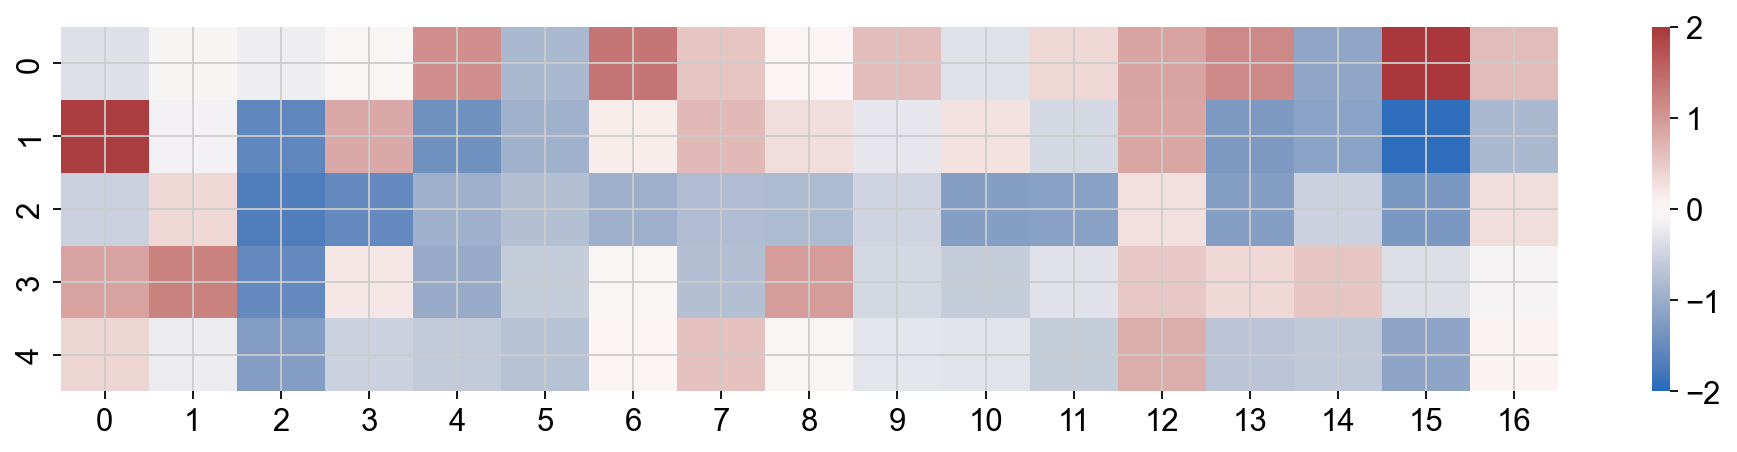

In [771]:
plt.figure(figsize=(15,3))
sns.heatmap(perturbation_downstream_df.T, cmap='vlag', vmin=-2, vmax=2, 
               xticklabels=perturbation_downstream_df.index,
               yticklabels=perturbation_downstream_df.columns)

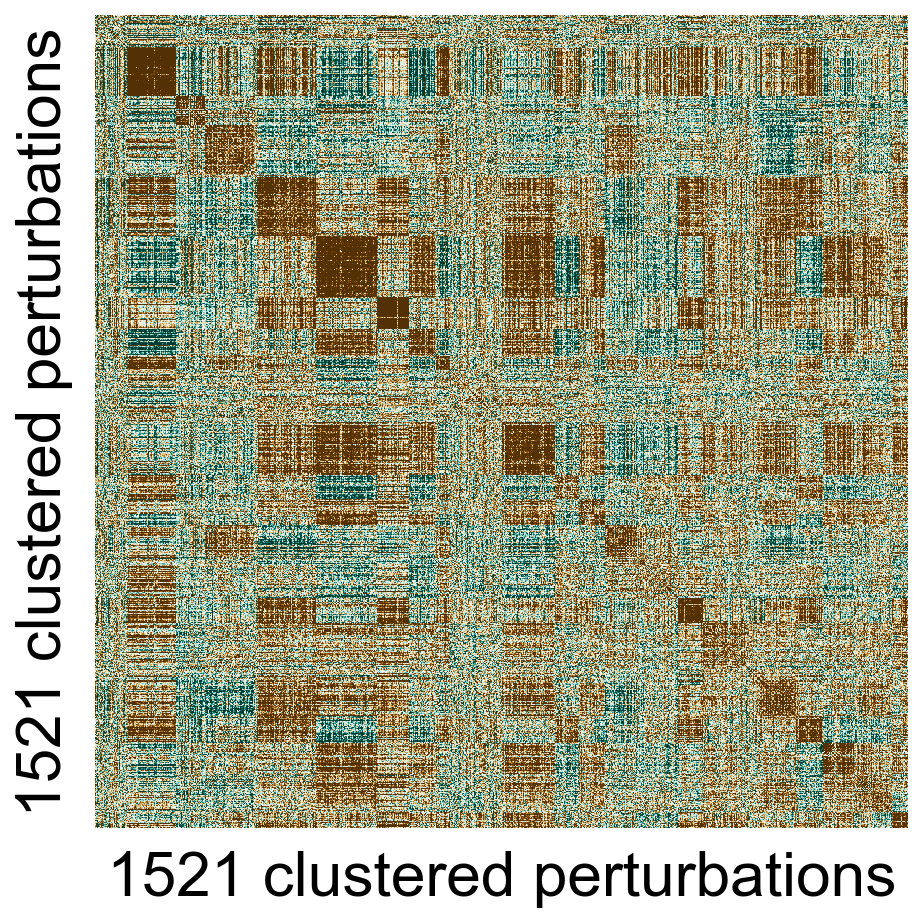

In [148]:
fig, ax = plt.subplots(figsize=(6,6))
data = np.empty([0,adata.shape[1]])
ind = []
for i in adata.obs['leiden_clusters'].unique():
    data = np.concatenate([data, adata[adata.obs['leiden_clusters']==i].layers['masked_zscore']])
    list1 = adata[adata.obs['leiden_clusters']==i].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata.obs['leiden_clusters']==i].obs.culture_condition.values.tolist()
    ind = ind +[f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]

df = pd.DataFrame(data=data, index=ind, columns=adata.var_names)
X = df.values
row_means = X.mean(axis=1, keepdims=True)
row_stds = X.std(axis=1, keepdims=True)
Z = (X - row_means) / row_stds
R_unscaled = Z @ Z.T
R = R_unscaled / (X.shape[1])
df_corr = pd.DataFrame(R, index=df.index.tolist(), columns=df.index.tolist())
sns.heatmap(df_corr, vmin=-0.3, vmax=0.3, xticklabels=False, yticklabels=False, cmap='BrBG_r', cbar=False, ax=ax, rasterized=True)
ax.set_xlabel(str(len(data))+' clustered perturbations', fontsize=28, labelpad=10)
ax.set_ylabel(str(len(data))+' clustered perturbations', fontsize=28, labelpad=10)
plt.tight_layout()

In [813]:
adata_all[adata_all.obs.leiden_clusters==5].obs.sort_values('target_contrast_gene_name')

target_contrast_gene_name  \
target_contrast_gene_name_corrected                             
ADAM19                                                 ADAM19   
AK3                                                       AK3   
ALKBH2                                                 ALKBH2   
ARMC8                                                   ARMC8   
C8orf33                                               C8orf33   
CASP3                                                   CASP3   
CCNC                                                     CCNC   
CCNK                                                     CCNK   
CIP2A                                                   CIP2A   
CSK                                                       CSK   
CXXC1                                                   CXXC1   
DDX42                                                   DDX42   
DPH6                                                     DPH6   
EHMT2                                                   EHMT2   
EIF3J                                                   EIF3J   
FKBP2                                                   FKBP2   
FOXK1                                                   FOXK1   
GOLT1B                                                 GOLT1B   
HIP1R                                                   HIP1R   
HMBS                                                     HMBS   
HNRNPA2B1                                           HNRNPA2B1   
HOXB4                                                   HOXB4   
INO80                                                   INO80   
INSIG1                                                 INSIG1   
IRF1                                                     IRF1   
IRF2BP1                                               IRF2BP1   
JAKMIP2                                               JAKMIP2   
POGLUT3                                                KDELC2   
KLF2                                                     KLF2   
KLHDC10                                               KLHDC10   
LRRC25                                                 LRRC25   
LTB4R                                                   LTB4R   
LZTS1                                                   LZTS1   
MAP3K5                                                 MAP3K5   
MCTS1                                                   MCTS1   
MED1                                                     MED1   
MED12                                                   MED12   
MED13                                                   MED13   
MED19                                                   MED19   
MED24                                                   MED24   
MLST8                                                   MLST8   
MOSPD2                                                 MOSPD2   
PAK2                                                     PAK2   
PCBP2                                                   PCBP2   
PCM1                                                     PCM1   
PEX6                                                     PEX6   
PIGB                                                     PIGB   
POLG                                                     POLG   
PPCDC                                                   PPCDC   
PRRC2A                                                 PRRC2A   
PTEN                                                     PTEN   
PUM1                                                     PUM1   
PXMP4                                                   PXMP4   
RASA2                                                   RASA2   
RNF20                                                   RNF20   
RNFT1                                                   RNFT1   
RNMT                                                     RNMT   
SARS2                                                   SARS2   
SETD1B                                                 SETD1B   
SIK3                                                     SIK3   
SLC9A5

In [785]:
adata_all[adata_all.obs.target_contrast_gene_name.isin(genelist)].obs.sort_values('target_contrast_gene_name')

target_contrast_gene_name  \
target_contrast_gene_name_corrected                             
ATP2A2                                                 ATP2A2   
CCNC                                                     CCNC   
CD3G                                                     CD3G   
CD28                                                     CD28   
CHD4                                                     CHD4   
CYB5R4                                                 CYB5R4   
ELOB                                                     ELOB   
GATA3                                                   GATA3   
ICOS                                                     ICOS   
IL2RB                                                   IL2RB   
IL4R                                                     IL4R   
KDM1A                                                   KDM1A   
MED12                                                   MED12   
MED24                                                   MED24   
MEN1                                                     MEN1   
MTOR                                                     MTOR   
NFKB2                                                   NFKB2   
PTEN                                                     PTEN   
PTPN2                                                   PTPN2   
PTPRC                                                   PTPRC   
RASA2                                                   RASA2   
RASGRP1                                               RASGRP1   
SGF29                                                   SGF29   
SMARCB1                                               SMARCB1   
STAT3                                                   STAT3   
STAT5B                                                 STAT5B   
STAT6                                                   STAT6   
TADA1                                                   TADA1   
TBX21                                                   TBX21   
TSC1                                                     TSC1   
TSC2                                                     TSC2   
USP22                                                   USP22   

                                    culture_condition  target_contrast chunk  \
target_contrast_gene_name_corrected                                            
ATP2A2                                        Stim8hr  ENSG00000174437   574   
CCNC                                          Stim8hr  ENSG00000112237   385   
CD3G                                          Stim8hr  ENSG00000160654   274   
CD28                                          Stim8hr  ENSG00000178562    99   
CHD4                                          Stim8hr  ENSG00000111642   209   
CYB5R4                                        Stim8hr  ENSG00000065615   426   
ELOB                                          Stim8hr  ENSG00000103363    44   
GATA3                                         Stim8hr  ENSG00000107485    77   
ICOS                                          Stim8hr  ENSG00000163600     0   
IL2RB                                         Stim8hr  ENSG00000100385    76   
IL4R                                          Stim8hr  ENSG00000077238   222   
KDM1A                                         Stim8hr  ENSG00000004487   447   
MED12                                         Stim8hr  ENSG00000184634   523   
MED24                                         Stim8hr  ENSG00000008838   257   
MEN1                                          Stim8hr  ENSG00000133895   120   
MTOR                                          Stim8hr  ENSG00000198793   557   
NFKB2                                         Stim8hr  ENSG00000077150   395   
PTEN                                          Stim8hr  ENSG00000171862   144   
PTPN2                                         Stim8hr  ENSG00000175354   395   
PTPRC                                         Stim8hr  ENSG00000081237   115   
RASA2                                         Stim8hr  ENSG000001

In [809]:
nde_thres = 100
mask = (de_summary_stats.n_total_de_genes>nde_thres) & (de_summary_stats.condition=='Stim8hr')
strong_gene_list = de_summary_stats[mask].target_name_corrected

In [831]:
np.max(np.abs(adata.layers['masked_zscore']),axis=1)>5

array([False,  True, False, ..., False, False, False])

In [835]:
mask = (adata_cytokine.layers['adj_p_value']<0.05).any(axis=1) & (np.max(np.abs(adata_cytokine.layers['masked_zscore']),axis=1)>5)
#mask = mask & np.max(np.abs(adata_cytokine.layers['masked_zscore']),axis=1)>5 # & (adata_cytokine.obs.target_contrast_gene_name_corrected.isin(strong_gene_list))
adata = adata_cytokine[mask].copy()
adata.var_names = adata.var.gene_name.copy()

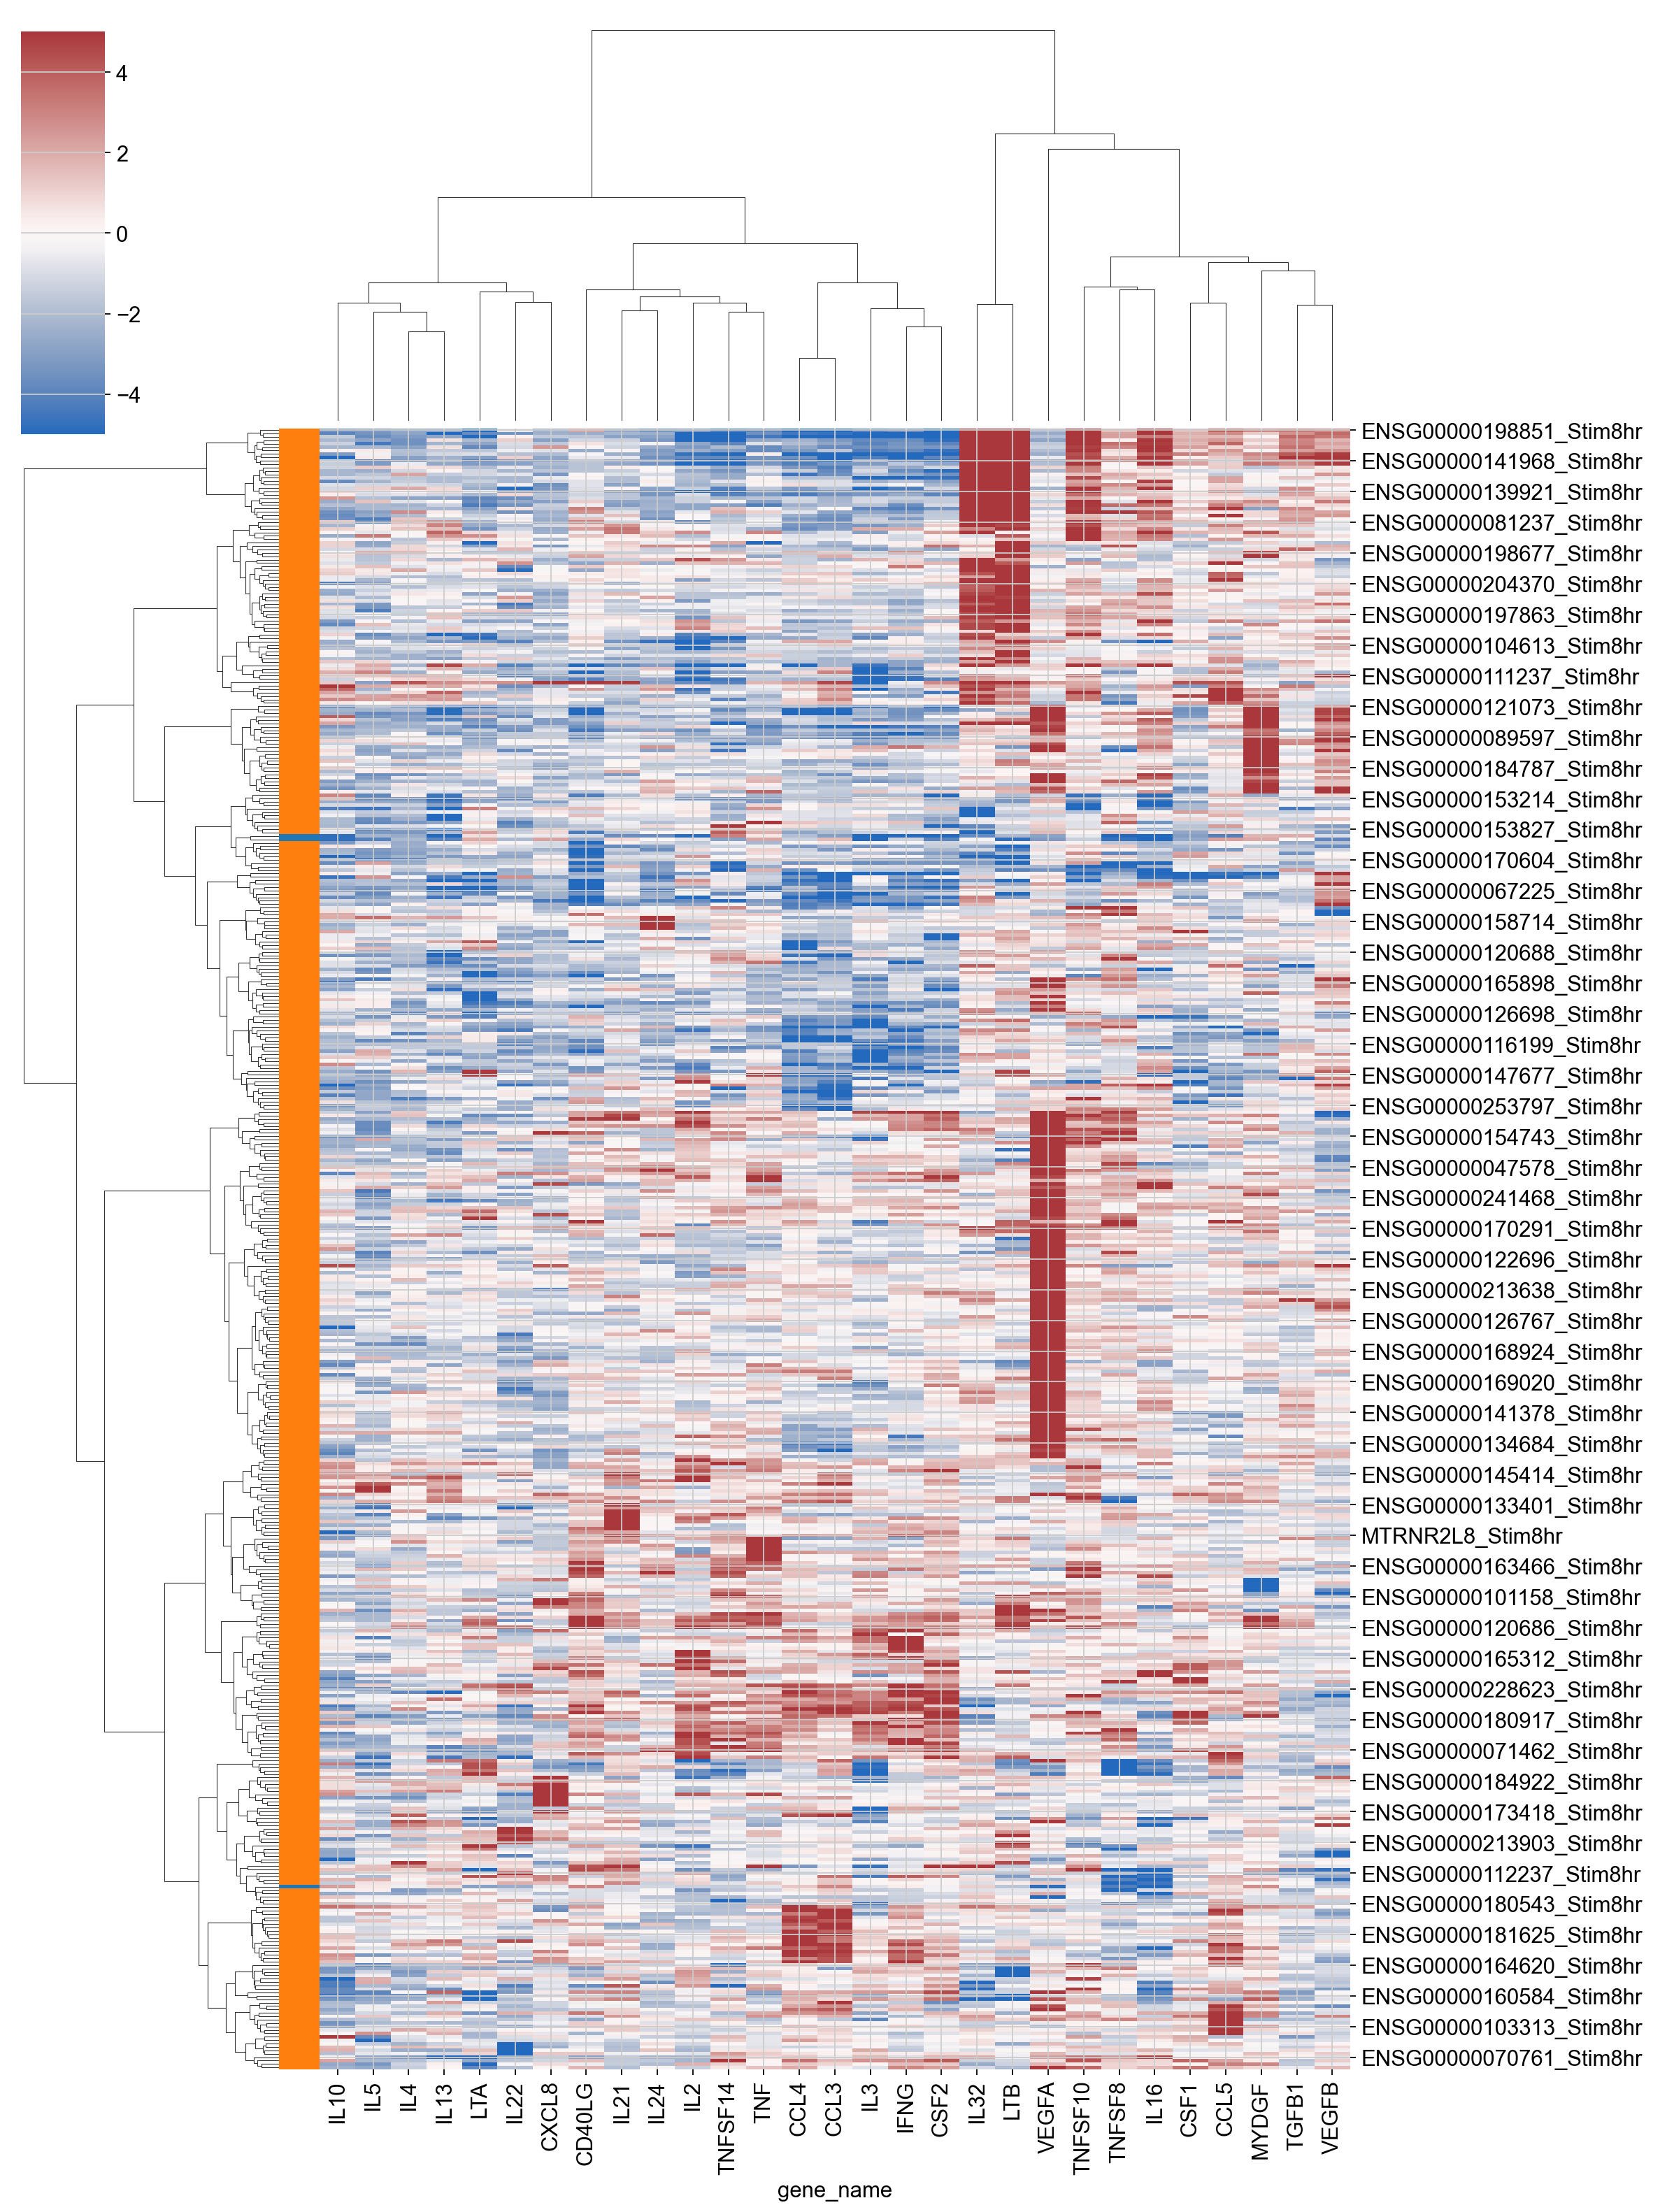

In [838]:
adata_scale = adata.copy()
#sc.pp.scale(adata_scale)
genelist = ['MED12', 'MED24', 'MED1', 'MED13', 'MED19']
#genelist = ['SGF29', 'TADA2B', 'TAF5L', 'TAF6L', 'TADA1']

# Create the new column
adata_scale.obs['highlight_group'] = 'Other'
adata_scale.obs.loc[adata_scale.obs['target_contrast_gene_name_corrected'].isin(genelist), 'highlight_group'] = 'Highlighted'
adata_scale.obs['highlight_group'] = adata_scale.obs['highlight_group'].astype('category')

# --- STEP 2: The updated clustermap command ---
sc.pl.clustermap(
    adata_scale,
    method = 'ward',
    obs_keys='highlight_group',
    vmin=-5,
    vmax=5,
    figsize=(15,20),
    cmap='vlag'
)

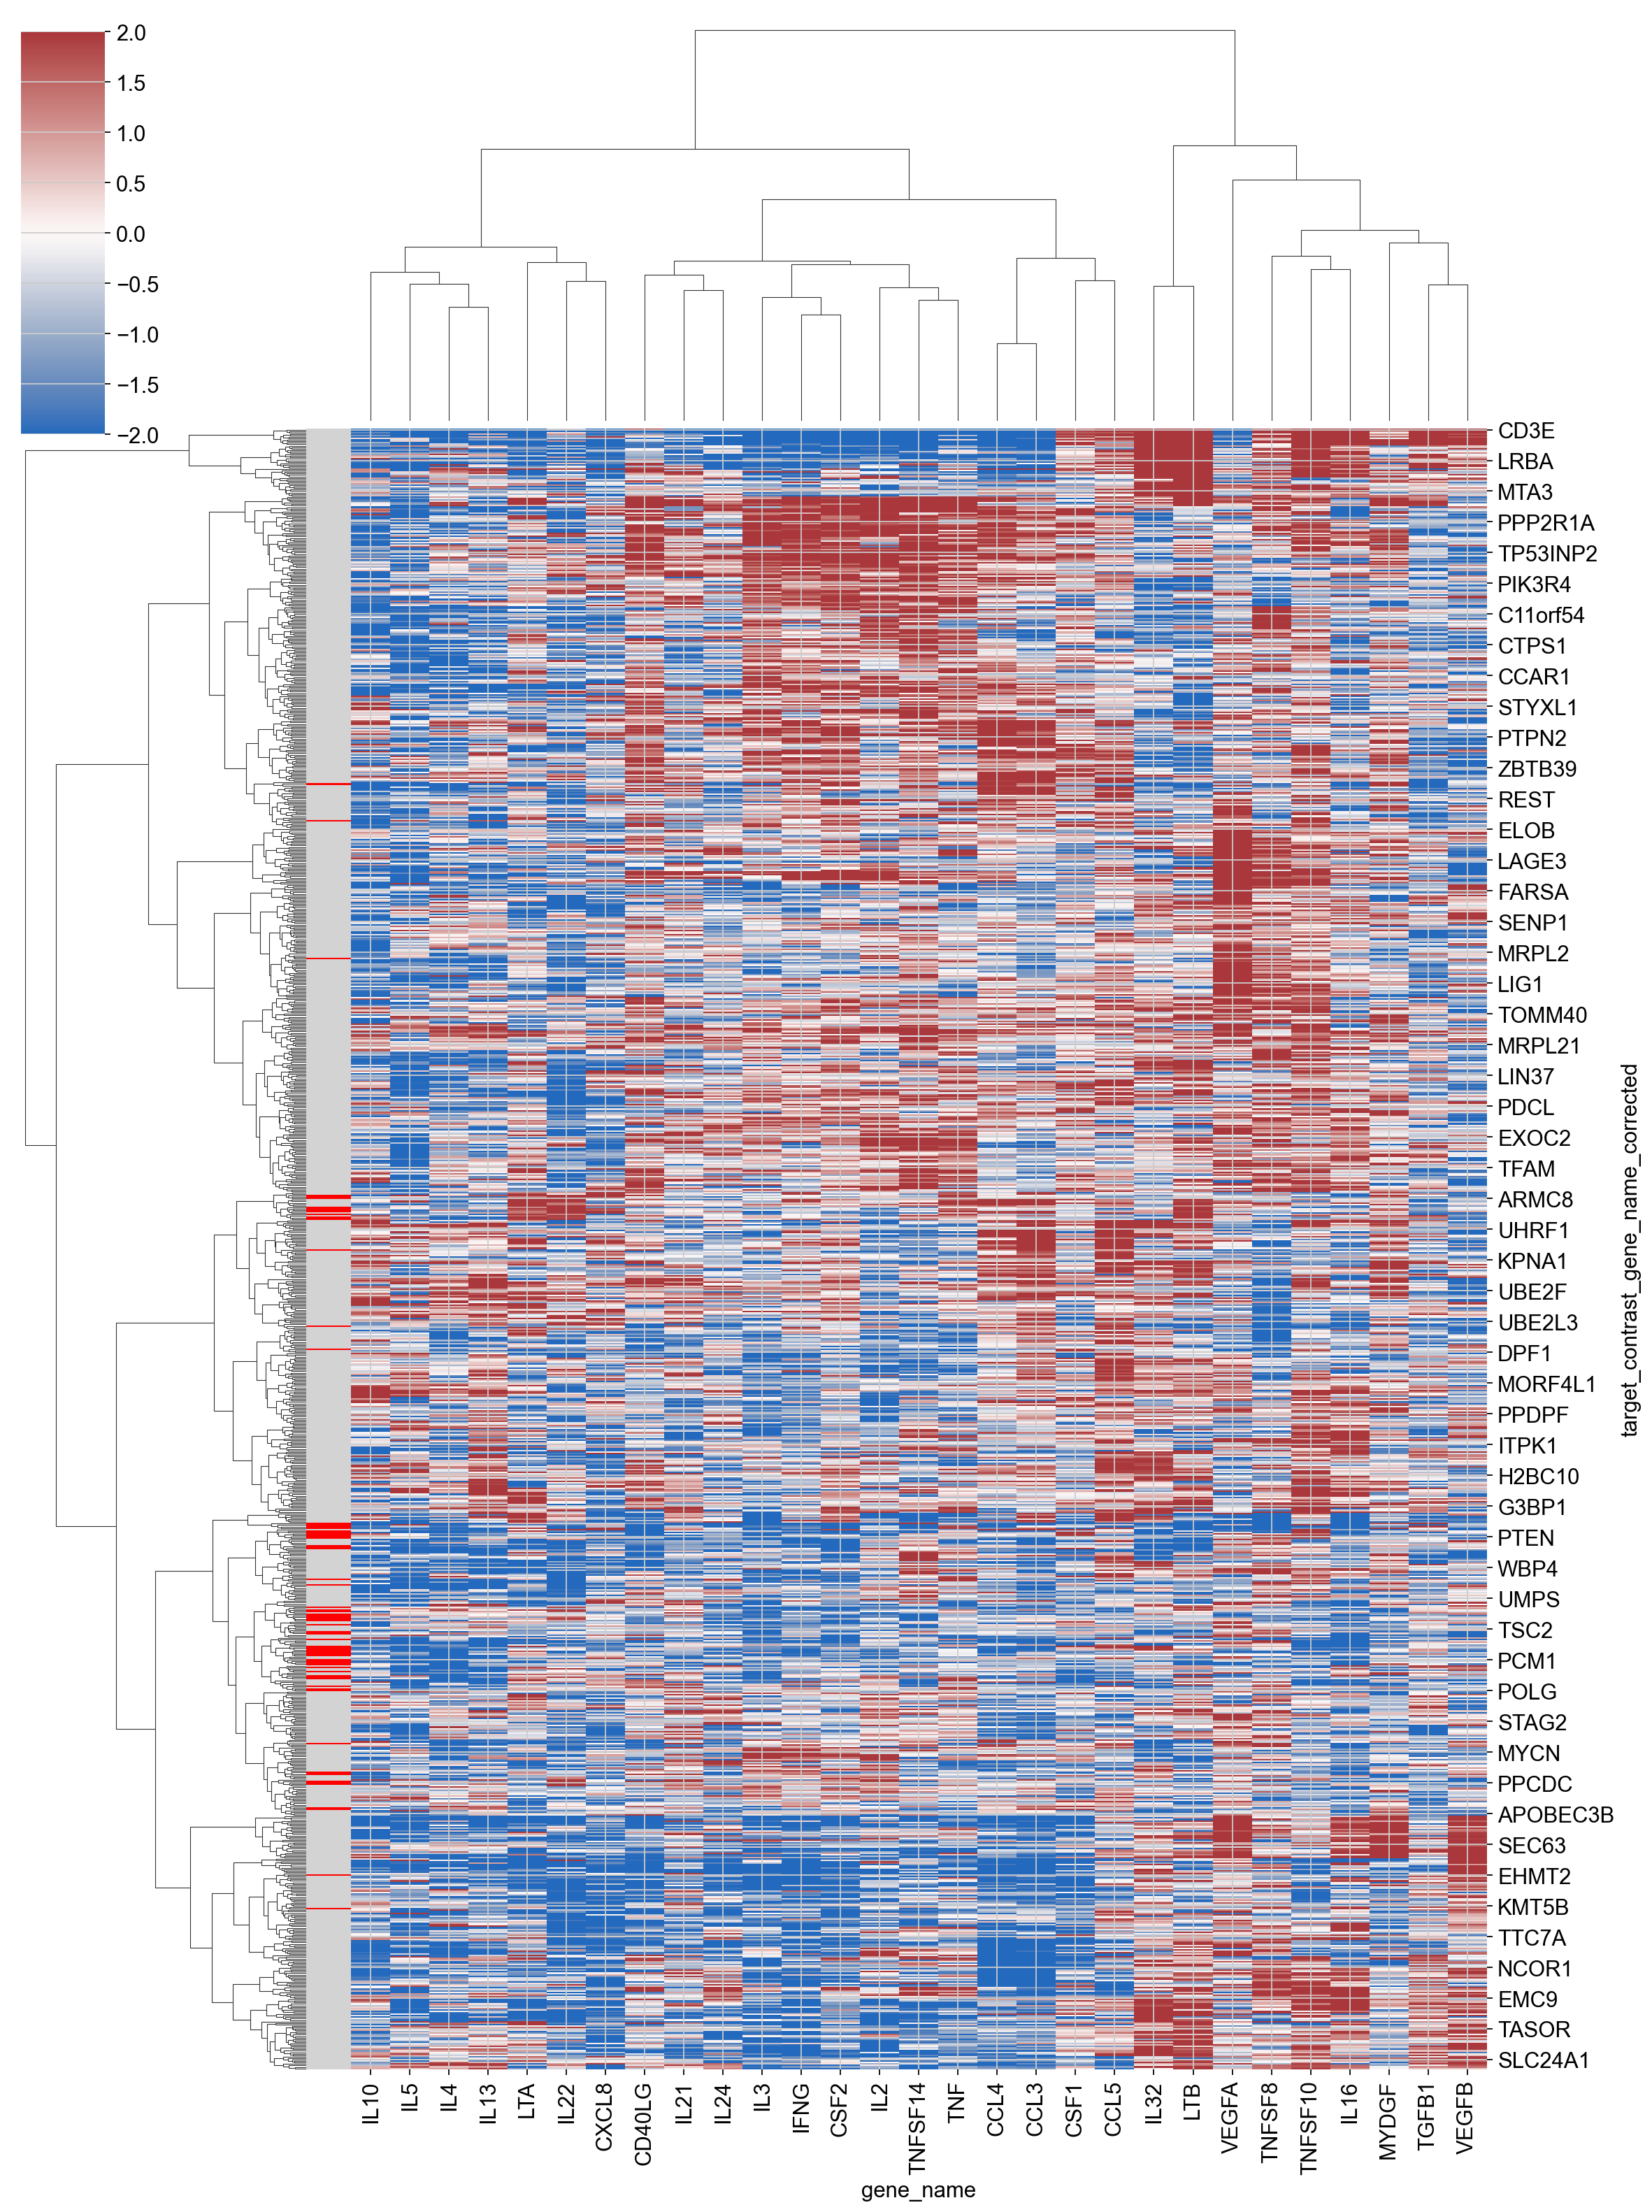

In [811]:
adata_scale = adata_all.copy()
#sc.pp.scale(adata_scale)
clusters_to_highlight = [2]#, 4, 5, 14, 15]
clusters_to_highlight = [5]

# Create the new column
adata_scale.obs['highlight_group'] = 'Other'
adata_scale.obs.loc[adata_scale.obs['leiden_clusters'].isin(clusters_to_highlight), 'highlight_group'] = 'Highlighted'
adata_scale.obs['highlight_group'] = adata_scale.obs['highlight_group'].astype('category')

# --- STEP 2: The updated clustermap command ---
sc.pl.clustermap(
    adata_scale,
    method = 'ward',
    obs_keys='highlight_group',
    vmin=-2,
    vmax=2,
    figsize=(15,20),
    cmap='vlag'
)

In [66]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
labels = clusterer.fit_predict(adata.X)
adata.obs['hdbscan_clusters'] = labels.astype(str)

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [67]:
adata.obs['hdbscan_clusters'].unique()

array(['-1', '1', '0'], dtype=object)